## ライブラリ

In [1]:
import random, copy, os
from graphviz import Graph
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import zss
import pyconll
import ot

from tqdm.notebook import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
!pip show ot

DEPRECATION: Loading egg at /misc/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/pqgrams-git.master-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


## 関数定義

In [3]:
def generate_random_tree(n): # サイズnのランダムな木構造を作成
    """
        辞書型のtreeで木構造を実現
        keyの子ノードをvalue（リスト）とする
    """
    random.seed(0) # 固定したいなら

    tree = {0: []}
    for i in range(1, n):
        parent = random.randint(0, i - 1)
        if parent not in tree:
            tree[parent] = []
        tree[parent].append(i)
        tree[i] = []
    return tree


def get_descendants(tree, node):
    """
        treeにおけるnodeのすべての子孫を再帰的に取得
    """
    desc = set()
    for child in tree[node]:
        desc.add(child)
        desc |= get_descendants(tree, child) # 和集合を取得 
    return desc


def propose_subtree_move(tree):
    """
        サブツリーを切り取って他の位置に接続する操作
    """
    tree = copy.deepcopy(tree)
    nodes = list(tree.keys())
    nodes.remove(0)
    v = random.choice(nodes)

    # 現在の親を探す
    parent_v = None
    for parent, children in tree.items():
        if v in children:
            parent_v = parent
            break

    # 切り離す
    tree[parent_v].remove(v)

    # 移動先の候補（子孫と自分自身を除く）
    descendants = get_descendants(tree, v)
    invalid = descendants | {v}
    candidates = [u for u in tree if u not in invalid]

    if not candidates:
        # 復元して元に戻す
        tree[parent_v].append(v)
        return tree

    new_parent = random.choice(candidates)
    tree[new_parent].append(v)

    return tree


def convert_to_zss(tree: dict[int, list[int]], labels: dict[int, str] = None) -> zss.Node:
    """
    dict形式の木構造（親→子）を zss.Node に変換する。
    
    Parameters:
        tree: 木構造（親 → 子リスト）
        labels: ノードID → ラベル（任意）。なければIDをそのまま文字列化

    Returns:
        zss.Node形式の根ノード
    """
    if labels is None:
        labels = {i: "_" for i in tree.keys()}

    def build_subtree(node_id: int) -> zss.Node:
        label = labels[node_id] if labels and node_id in labels else str(node_id)
        children = [build_subtree(child_id) for child_id in tree.get(node_id, [])]
        return zss.Node(label, children)

    return build_subtree(0)  # 0 を根として仮定


def conll_to_zss_unlabel(tree: pyconll.tree)->zss.Node:
    node = zss.Node("_")
    for child in tree:
        node.addkid(conll_to_zss_unlabel(child))
    return node



In [4]:
def zss_to_dict(zss_node: zss.Node) -> dict[int, list[int]]:
    """
    zss形式の木構造を dict形式（親 → 子リスト）に変換する。
    
    Parameters:
        zss_node: zss.Node形式の根ノード

    Returns:
        dict形式の木構造
    """
    tree = {}
    node_counter = [0]  # ノードIDを管理するためのリスト（ミュータブル）

    def build_tree(node: zss.Node, parent_id=None):
        node_id = node_counter[0]
        node_counter[0] += 1

        # 子ノードのラベルを取得
        children_ids = []
        for child in node.children:
            try:
                child_id = node_counter[0]
                children_ids.append(child_id)
                build_tree(child, parent_id=node_id)
            except Exception as e:
                print(f"Error processing child node: {e}")

        # 現在のノードをツリーに追加
        tree[node_id] = children_ids

    build_tree(zss_node)
    return tree

In [5]:
def build_graph(node, graph, nodes, parent=None):
    """
    ツリー構造 (zss.Node) を無向グラフに変換します。
    graph は、各ノードの id をキー、その隣接ノード（id）のリストを値とする辞書です。
    nodes は、id をキー、対応する zss.Node を値とする辞書です。
    """
    node_id = id(node)
    if node_id not in graph:
        graph[node_id] = []
        nodes[node_id] = node
    if parent is not None:
        parent_id = id(parent)
        # 双方向リンクを追加
        graph[node_id].append(parent_id)
        graph[parent_id].append(node_id)
    for child in node.children:
        build_graph(child, graph, nodes, node)

def dfs_graph(graph, node_id, parent_id, depth):
    """
    無向グラフ上で DFS を行い、現在のノードから到達可能な最大の深さと
    そのノードの id を返します。
    
    引数:
      graph     : ノードidをキーとした隣接リストの辞書
      node_id   : 現在のノードの id
      parent_id : 一つ前に訪れたノードの id（これにより逆流を防止）
      depth     : 現在までの深さ
    戻り値:
      (max_depth, farthest_node_id)
    """
    max_depth = depth
    farthest_node_id = node_id
    for neighbor in graph[node_id]:
        if neighbor == parent_id:
            continue
        child_depth, candidate = dfs_graph(graph, neighbor, node_id, depth + 1)
        if child_depth > max_depth:
            max_depth = child_depth
            farthest_node_id = candidate
    return max_depth, farthest_node_id

def tree_diameter(root):
    """
    zss.Node で表現されたツリーの直径（最長経路の辺の数）を DFS 2 回で求める関数です。
    
    手順:
      1. ツリーを無向グラフに変換（id をキーとする）
      2. 任意のノード（ここでは root）から DFS を実施し、最も遠いノード node_u を取得する
      3. node_u を起点に DFS を実施し、そこから到達可能な最遠距離が直径となる
    """
    graph = {}
    nodes = {}
    build_graph(root, graph, nodes)
    
    # 1回目の DFS: root から最も遠いノードを求める
    _, farthest_node_id = dfs_graph(graph, id(root), None, 0)
    # print(f"First DFS: farthest node from 'root' is '{nodes[farthest_node_id].label}'")
    
    # 2回目の DFS: farthest_node_id からの最大距離を直径とする
    diameter, _ = dfs_graph(graph, farthest_node_id, None, 0)
    return diameter

def tree_height(node):
    """
    zss.Node で表現された木の高さ（根から最も深い葉までのエッジ数）を再帰的に求める関数です。
    
    もしノードが葉（子ノードが存在しない）であれば高さは 0 と定義します。
    ノードに子がある場合、その最大の高さに 1 を加えたものがそのノードの高さとなります。
    """
    # 葉ノードの場合は 0 を返す
    if not node.children:
        return 0
    # 各子ノードについて再帰的に木の高さを計算し、最大値に 1 を加える
    return max(tree_height(child) for child in node.children) + 1


In [6]:
def compute_branch_factors(root):
    """
    ツリー内の全ノードについて、分岐数（子ノードの数）を集計し、
    平均分岐数と最大分岐数を返す関数です。
    
    平均分岐数は「すべてのノードの子の数の合計 ÷ ノード数」
    最大分岐数は「各ノードの子ノード数の中で最大の値」となります。
    
    Args:
        root (zss.Node): ツリーの根ノード
        
    Returns:
        tuple: (平均分岐数, 最大分岐数)
    """
    total_children = 0  # 全ノードの子ノードの合計
    total_nodes = 0     # ツリー内のノード数
    max_children = 0    # 各ノードの子ノード数の最大値

    def dfs(node):
        nonlocal total_children, total_nodes, max_children
        # 現在のノードの子ノード数を取得
        children_count = len(node.children)
        total_children += children_count
        total_nodes += 1
        # 最大値の更新
        if children_count > max_children:
            max_children = children_count
        # 子ノードについて再帰呼び出し
        for child in node.children:
            dfs(child)

    dfs(root)
    # 平均分岐数はノード数が 0 でなければ計算する
    average = total_children / total_nodes if total_nodes > 0 else 0
    return average, max_children

In [7]:
def calc_linearity(tree):
    """
    木の線形性を計算する関数です。
    
    Args:
        tree (zss.Node): ツリーの根ノード
        
    Returns:
        float: 線形性
    """
    diameter = tree_diameter(tree)
    height = tree_height(tree)
    branch_avg, branch_max = compute_branch_factors(tree)
    return (1 - branch_avg / branch_max) * diameter / height

In [8]:
# 線形の木を生成
def generate_linear_tree(n):
    """
    サイズ n の線形木を生成する関数
    """
    tree = {i: [i + 1] for i in range(n - 1)}
    tree[n - 1] = []
    return tree


# サイズnの完全二分木を生成
def generate_full_binary_tree(n):
    """
    サイズ n の完全二分木を生成する関数
    """
    tree = {i: [] for i in range(n)}
    for i in range(n):
        left_child = 2 * i + 1
        right_child = 2 * i + 2
        if left_child < n:
            tree[i].append(left_child)
        if right_child < n:
            tree[i].append(right_child)

    return tree


# スター木を生成
def generate_star_tree(n):
    """
    サイズ n のスター木を生成する関数
    """
    tree = {0: list(range(1, n))}
    for i in range(1, n):
        tree[i] = []
    return tree


# サイズnの完全二分木を生成
def generate_full_binary_tree(n):
    """
    サイズ n の完全二分木を生成する関数
    """
    tree = {i: [] for i in range(n)}
    for i in range(n):
        left_child = 2 * i + 1
        right_child = 2 * i + 2
        if left_child < n:
            tree[i].append(left_child)
        if right_child < n:
            tree[i].append(right_child)

    return tree

In [9]:
def zss_to_dict(zss_node: zss.Node) -> dict[int, list[int]]:
    """
    zss形式の木構造を dict形式（親 → 子リスト）に変換する。
    
    Parameters:
        zss_node: zss.Node形式の根ノード

    Returns:
        dict形式の木構造
    """
    tree = {}

    def build_tree(node: zss.Node, index=0):
        node_id = index  # ラベルを整数として扱う
        tree[node_id] = [index+i+1 for i in range(len(node.children))]
        for i, child in enumerate(node.children):
            build_tree(child, index=node_id+i+1)

    build_tree(zss_node)
    return tree

In [10]:
def calc_diameter(tree_list: list):
    """
        TEDを利用して、集合の距離を計算
    """
    tree_count = len(tree_list)
    max_distance = 0
    for i in tqdm(range(tree_count)):
        for j in range(i+1, tree_count):
            dist_ij = zss.simple_distance(tree_list[i], tree_list[j])
            if max_distance < dist_ij:
                max_distance = dist_ij
    return max_distance


In [11]:
def calc_wasserstein_dist(src_tree: list, tar_tree: list):
    """
        Wasserstein距離を計算する関数
        src_tree: ソースツリーのリスト
        tar_tree: ターゲットツリーのリスト
    """
    num_src = len(src_tree)
    num_tar = len(tar_tree)
    a = [1/num_src] * num_src
    b = [1/num_tar] * num_tar

    cost_matrix = np.zeros((num_src, num_tar))
    for i in range(num_src):
        for j in range(num_tar):
            cost_matrix[i, j] = zss.simple_distance(src_tree[i], tar_tree[j])

    wasserstein_distance = ot.emd2(a, b, cost_matrix, numItermax=1000000)
    return wasserstein_distance

In [12]:
def tsne_distmx(path: str)->np.ndarray:
    """
    距離行列を読み込み、t-SNEで次元削減を行う関数
    """
    distance_matrix = np.load(path)
    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)
    return X_reduced

# 実行部分

## 前提

In [13]:
N = 20  # 木のノード数 

In [14]:
conll_nl = pyconll.load_from_file("/home/yamazoe/zoe/data/arranged/corpora_20/English-EWT_20.conllu")
random.seed(0)
conll_nl = random.sample(conll_nl, k=100)
tree_nl = [conll.to_tree() for conll in conll_nl]
tree_nl_zss = [conll_to_zss_unlabel(tree) for tree in tree_nl]
tree_nl = [zss_to_dict(tree) for tree in tree_nl_zss]

In [15]:
# 初期状態がEWTの木
t_init = tree_nl[0]

tree_ewt_10000 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_ewt_10000.append(tree)

tree_ewt_100 = tree_ewt_10000[:100]
tree_ewt_100_zss = [convert_to_zss(tree) for tree in tree_ewt_100]
random.seed(0)
tree_ewt_10000r = random.sample(tree_ewt_10000, k=100)
tree_ewt_10000r_zss = [convert_to_zss(tree) for tree in tree_ewt_10000r]
tree_ewt_10000l = tree_ewt_10000[-100:]
tree_ewt_10000l_zss = [convert_to_zss(tree) for tree in tree_ewt_10000l]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
t_init = generate_full_binary_tree(20)

tree_binary_10000 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_binary_10000.append(tree)

tree_binary_100 = tree_binary_10000[:100]
tree_binary_100_zss = [convert_to_zss(tree) for tree in tree_binary_100]
random.seed(0)
tree_binary_10000r = random.sample(tree_binary_10000, k=100)
tree_binary_10000r_zss = [convert_to_zss(tree) for tree in tree_binary_10000r]
tree_binary_10000l = tree_binary_10000[-100:]
tree_binary_10000l_zss = [convert_to_zss(tree) for tree in tree_binary_10000l]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
t_init = generate_linear_tree(20)

tree_linear_10000 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_linear_10000.append(tree)

tree_linear_100 = tree_linear_10000[:100]
tree_linear_100_zss = [convert_to_zss(tree) for tree in tree_linear_100]
random.seed(0)
tree_linear_10000r = random.sample(tree_linear_10000, k=100)
tree_linear_10000r_zss = [convert_to_zss(tree) for tree in tree_linear_10000r]
tree_linear_10000l = tree_linear_10000[-100:]
tree_linear_10000l_zss = [convert_to_zss(tree) for tree in tree_linear_10000l]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
t_init = generate_star_tree(20)

tree_star_10000 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_star_10000.append(tree)

tree_star_100 = tree_star_10000[:100]
tree_star_100_zss = [convert_to_zss(tree) for tree in tree_star_100]
random.seed(0)
tree_star_10000r = random.sample(tree_star_10000, k=100)
tree_star_10000r_zss = [convert_to_zss(tree) for tree in tree_star_10000r]
tree_star_10000l = tree_star_10000[-100:]
tree_star_10000l_zss = [convert_to_zss(tree) for tree in tree_star_10000l]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
PATH_ENGLISH_20 = "/home/yamazoe/zoe/data/arranged/corpora_20/English-EWT_20.conllu"
PATH_JAPANESE_20 = "/home/yamazoe/zoe/data/arranged/corpora_20/Japanese-GSDLUW_20.conllu"
PATH_CHINESE_20 = "/home/yamazoe/zoe/data/arranged/corpora_20/Chinese-GSD_20.conllu"
PATH_KOREAN_20 = "/home/yamazoe/zoe/data/arranged/corpora_20/Korean-Kaist_20.conllu"
PATH_FRENCH_20 = "/home/yamazoe/zoe/data/arranged/corpora_20/French-GSD_20.conllu"

In [20]:
conll_en = pyconll.load_from_file(PATH_ENGLISH_20)
random.seed(0)
conll_en = random.sample(conll_en, k=100)
tree_en = [conll.to_tree() for conll in conll_en]
tree_en_zss = [conll_to_zss_unlabel(tree) for tree in tree_en]


conll_ja = pyconll.load_from_file(PATH_JAPANESE_20)
random.seed(0)
conll_ja = random.sample(conll_ja, k=100)
tree_ja = [conll.to_tree() for conll in conll_ja]
tree_ja_zss = [conll_to_zss_unlabel(tree) for tree in tree_ja]


conll_ko = pyconll.load_from_file(PATH_KOREAN_20)
random.seed(0)
conll_ko = random.sample(conll_ko, k=100)
tree_ko = [conll.to_tree() for conll in conll_ko]
tree_ko_zss = [conll_to_zss_unlabel(tree) for tree in tree_ko]


conll_ch = pyconll.load_from_file(PATH_CHINESE_20)
random.seed(0)
conll_ch = random.sample(conll_ch, k=100)
tree_ch = [conll.to_tree() for conll in conll_ch]
tree_ch_zss = [conll_to_zss_unlabel(tree) for tree in tree_ch]


conll_fr = pyconll.load_from_file(PATH_FRENCH_20)
random.seed(0)
conll_fr = random.sample(conll_fr, k=100)
tree_fr = [conll.to_tree() for conll in conll_fr]
tree_fr_zss = [conll_to_zss_unlabel(tree) for tree in tree_fr]

In [21]:
LANG = sorted(["en", "ja", "ko", "ch", "fr"])
corpus_dict = {
    "en": "English-EWT",
    "ja": "Japanese-GSDLUW",
    "ko": "Korean-Kaist",
    "ch": "Chinese-GSD",
    "fr": "French-GSD"
}


In [22]:
DIST_MX_DIR = "/home/yamazoe/zoe/data/numpy_data/distmx/mcmc-ewt/"
SCATTER_DIR = "/home/yamazoe/zoe/figures/scatter/MCMC/"
PATH_ENGLISH_EWT = "/home/yamazoe/zoe/data/original/treebank/English/English-EWT.conllu"

## サンプル

In [2]:
tree = generate_random_tree(N) # ランダムな木の生成(MCMCの初期状態)

NameError: name 'generate_random_tree' is not defined

In [ ]:
# MCMC サンプリングの実施
tree_mcmc = []

for step in tqdm(range(100)):
    tree = propose_subtree_move(tree)
    tree_mcmc.append(tree)

tree_mcmc = [convert_to_zss(t) for t in tree_mcmc]

In [ ]:
tree_count = len(tree_mcmc)

distance_matrix = np.zeros((tree_count, tree_count))

for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_mcmc[i], tree_mcmc[j])

distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
distance_matrix.max()

In [ ]:
conll_nl = pyconll.load_from_file("/home/yamazoe/zoe/data/arranged/corpora_20/English-EWT_20.conllu")
conll_nl = random.sample(conll_nl, k=100)
tree_nl = [conll.to_tree() for conll in conll_nl]
tree_nl = [conll_to_zss_unlabel(tree) for tree in tree_nl]

In [ ]:
t_nl = zss_to_dict(tree_nl[0])
dict(sorted(t_nl.items(), key=lambda x:x[0]))

In [ ]:
tree = zss_to_dict(tree_nl[0])

tree_mcmc = []

for step in tqdm(range(100)):
    tree = propose_subtree_move(tree)
    tree_mcmc.append(tree)

tree_mcmc = [convert_to_zss(t) for t in tree_mcmc]

In [ ]:
tree_all = tree_mcmc + tree_nl
tree_count = len(tree_all)

distance_matrix = np.zeros((tree_count, tree_count))
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_all[i], tree_all[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
diameter = distance_matrix.max()
diameter

In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)
fig, ax = plt.subplots()

ax.scatter(X_reduced[:100,0], X_reduced[:100,1], label="MCMC")
ax.scatter(X_reduced[100:,0], X_reduced[100:,1], label="EWT")

ax.legend()

In [ ]:
tree_count = len(tree_mcmc)

distance_matrix = np.zeros((tree_count, tree_count))

for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_mcmc[i], tree_mcmc[j])

distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
diameter = distance_matrix.max()

In [ ]:
diameter

In [ ]:
type(diameter)

In [ ]:
trees = tree_mcmc + tree_nl

In [ ]:
# 距離行列の作成
tree_count = len(trees)

distance_matrix = np.zeros((tree_count, tree_count))

for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(trees[i], trees[j])

distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
print(distance_matrix)

In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X_reduced[:100,0], X_reduced[:100,1])
ax.scatter(X_reduced[100:,0], X_reduced[100:,1])

In [ ]:
DIST_MX_DIR = "../../data/numpy_data/distmx/mcmc-ewt/"
def tsne_distmx(path: str)->np.ndarray:
    """
    距離行列を読み込み、t-SNEで次元削減を行う関数
    """
    distance_matrix = np.load(path)
    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)
    return X_reduced

## 線形度合いの算出

In [ ]:
diameter = tree_diameter(tree_mcmc[0])
height = tree_height(tree_mcmc[0])
branch_avg, branch_max = compute_branch_factors(tree_mcmc[0])
diameter, height, branch_avg, branch_max

In [ ]:
(1-branch_avg/branch_max)*diameter/height

In [ ]:
t = generate_linear_tree(8)
calc_linearity(convert_to_zss(t))

In [ ]:
calc_linearity(convert_to_zss(generate_full_binary_tree(20)))

0.9187500000000001

In [ ]:
compute_branch_factors(convert_to_zss(generate_star_tree(20)))

In [ ]:
generate_full_binary_tree(20)

In [ ]:
propose_subtree_move(generate_linear_tree(20))

In [ ]:
linearity_mcmc = [calc_linearity(t) for t in tree_mcmc]
linearity_nl = [calc_linearity(t) for t in tree_nl]

In [ ]:
plt.hist(linearity_mcmc, bins=20, alpha=0.5, label='MCMC')
plt.hist(linearity_nl, bins=20, alpha=0.5, label='English-EWT')
plt.axvline(x=calc_linearity(linear_tree), color='r', linestyle='--', label='Linear Tree')
plt.axvline(x=calc_linearity(binary_tree), color='g', linestyle='--', label='Binary Tree')
plt.axvline(x=calc_linearity(star_tree), color='b', linestyle='--', label='Star Tree')
plt.xlabel('Linearity')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
linearity_mcmc_binary_100 = [calc_linearity(t) for t in tree_binary_100_zss]
linearity_mcmc_binary_10000r = [calc_linearity(t) for t in tree_binary_10000r_zss]
linearity_mcmc_binary_10000l = [calc_linearity(t) for t in tree_binary_10000l_zss]

linearity_mcmc_ewt_100 = [calc_linearity(t) for t in tree_ewt_100_zss]
linearity_mcmc_ewt_10000r = [calc_linearity(t) for t in tree_ewt_10000r_zss]
linearity_mcmc_ewt_10000l = [calc_linearity(t) for t in tree_ewt_10000l_zss]

linearity_mcmc_star_100 = [calc_linearity(t) for t in tree_star_100_zss]
linearity_mcmc_star_10000r = [calc_linearity(t) for t in tree_star_10000r_zss]
linearity_mcmc_star_10000l = [calc_linearity(t) for t in tree_star_10000l_zss]

linearity_mcmc_linear_100 = [calc_linearity(t) for t in tree_linear_100_zss]
linearity_mcmc_linear_10000r = [calc_linearity(t) for t in tree_linear_10000r_zss]
linearity_mcmc_linear_10000l = [calc_linearity(t) for t in tree_linear_10000l_zss]

In [ ]:
linearity_EWT = [calc_linearity(t) for t in tree_en_zss]

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# --- 1) scatter プロットのみ ---
# （各サブプロットでは legend() を呼ばない）
for i, init in enumerate(['binary','ewt','linear','star']):
    for j, samp in enumerate(['100','10000l','10000r']):
        A = globals()[f"linearity_mcmc_{init}_{samp}"]  # 例: X_reduced_binary_100
        ax[i][j].hist(A, bins=20, alpha=0.5, label='MCMC')
        ax[i][j].hist(linearity_EWT, bins=20, alpha=0.5, label="EWT")
        ax[i][j].axvline(x=calc_linearity(convert_to_zss(generate_linear_tree(N))), color='r', linestyle='--', label='Linear Tree')
        ax[i][j].axvline(x=calc_linearity(convert_to_zss(generate_full_binary_tree(N))), color='g', linestyle='--', label='Binary Tree')
        ax[i][j].axvline(x=calc_linearity(convert_to_zss(generate_star_tree(N))), color='b', linestyle='--', label='Star Tree')
        samp_txt = {"100": "sampling:100", "10000l": "sampling:10000(last 100)", "10000r": "sampling:10000(random 100)"}
        ax[i][j].set_title(f"init:{init}, {samp_txt[samp]}\navg:{np.mean(A):.2f}, std:{np.std(A):.2f}")

# --- 2) 代表の Axes から handles/labels を取得 ---
handles, labels = ax[0][0].get_legend_handles_labels()

# --- 3) Figure レベルでまとめて凡例を描画 ---
leg = fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    frameon=True,        # 枠を表示
    fancybox=False,      # 角丸なし → 四角枠
    borderpad=0.5,       # 枠まわりの余白
    labelspacing=0.5     # ラベルどうしの間隔
)

# 凡例の分スペースを空ける
fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.5)

plt.savefig("/home/yamazoe/zoe/figures/histgram/linearity_mcmc.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
linearity_mean = [[""] * 3 for _ in range(4)]

for i, init in enumerate(['binary','ewt','linear','star']):
    for j, samp in enumerate(['100','10000l','10000r']):
        A = globals()[f"linearity_mcmc_{init}_{samp}"]  # 例: X_reduced_binary_100
        linearity_mean[i][j] = f"{np.mean(A):.2f}±{np.std(A):.2f}"

In [ ]:
df_linearity = pd.DataFrame(linearity_mean)
df_linearity.columns = ['sampling:100', 'sampling:10000(last 100)', 'sampling:10000(random 100)']
df_linearity.index = ['binary', 'ewt', 'linear', 'star']
df_linearity

In [ ]:
df_linearity.to_csv("/home/yamazoe/zoe/data/csv/linearity_mcmc.csv", index=True, header=True)

In [ ]:
l = ["English-EWT","Japanese-GSDLUW","Korean-Kaist","Chinese-GSD", "French-GSD"]
column_list = sorted(l)

df = pd.DataFrame(data=[[""] * 5 for _ in range(2)], index=["treebank","linearity"]).T
df["treebank"] = column_list

for i, lang in (enumerate(LANG)):
    A = globals()[f"tree_{lang}_zss"] 
    #print(lang, corpus_dict[lang])
    df.loc[i, "treebank"] = corpus_dict[lang]
    linearities = []
    for tree in A:
        linearities.append(calc_linearity(tree))
    df.loc[i, "linearity"] = f"{np.mean(linearities):.2f}±{np.std(linearities):.2f}"

In [ ]:
df.to_csv("/home/yamazoe/zoe/data/csv/linearity_NL.csv", index=False)

## tSNEによる分布

In [ ]:
tree = generate_linear_tree(N)
# MCMC サンプリングの実施
tree_mcmc = []

for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_mcmc.append(tree)

#random.seed(0)
#tree_mcmc = random.sample(tree_mcmc, k=100)
tree_mcmc = [convert_to_zss(t) for t in tree_mcmc[:100]]
#tree_mcmc = [convert_to_zss(t) for t in tree_mcmc[-100:]]

In [ ]:
tree_all = tree_mcmc + tree_nl
tree_count = len(tree_all)

distance_matrix = np.zeros((tree_count, tree_count))
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_all[i], tree_all[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())


In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)
fig, ax = plt.subplots()

ax.scatter(X_reduced[:100,0], X_reduced[:100,1], label="MCMC")
ax.scatter(X_reduced[100:,0], X_reduced[100:,1], label="EWT")

ax.legend()

In [ ]:
conll_nl = pyconll.load_from_file("/home/yamazoe/zoe/data/arranged/corpora_20/English-EWT_20.conllu")
conll_nl = random.sample(conll_nl, k=100)
tree_nl = [conll.to_tree() for conll in conll_nl]
tree_nl = [conll_to_zss_unlabel(tree) for tree in tree_nl]
tree_nl = [zss_to_dict(tree) for tree in tree_nl]

In [ ]:
t_nl = tree_nl[0]

tree_ewt_100 = []
tree = t_nl
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_ewt_100.append(tree)
tree_ewt_100 = tree_ewt_100[:100] + tree_nl

tree_ewt_10000r = []
tree = t_nl
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_ewt_10000r.append(tree)
tree_ewt_10000r = random.sample(tree_ewt_10000r, k=100) + tree_nl

tree_ewt_10000l = []
tree = t_nl
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_ewt_10000l.append(tree)
tree_ewt_10000l = tree_ewt_10000l[-100:] + tree_nl

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t_init = generate_full_binary_tree(20)

tree_binary_100 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_binary_100.append(tree)
tree_binary_100 = tree_binary_100[:100] + tree_nl

tree_binary_10000r = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_binary_10000r.append(tree)
tree_binary_10000r = random.sample(tree_binary_10000r, k=100) + tree_nl

tree_binary_10000l = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_binary_10000l.append(tree)
tree_binary_10000l = tree_binary_10000l[-100:] + tree_nl

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t_init = generate_linear_tree(20)

tree_linear_100 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_linear_100.append(tree)
tree_linear_100 = tree_linear_100[:100] + tree_nl

tree_linear_10000r = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_linear_10000r.append(tree)
tree_linear_10000r = random.sample(tree_linear_10000r, k=100) + tree_nl

tree_linear_10000l = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_linear_10000l.append(tree)
tree_linear_10000l = tree_linear_10000l[-100:] + tree_nl

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t_init = generate_star_tree(20)

tree_star_100 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_star_100.append(tree)
tree_star_100 = tree_star_100[:100] + tree_nl

tree_star_10000r = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_star_10000r.append(tree)
tree_star_10000r = random.sample(tree_star_10000r, k=100) + tree_nl

tree_star_10000l = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_star_10000l.append(tree)
tree_star_10000l = tree_star_10000l[-100:] + tree_nl

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t_init = generate_random_tree(20)

tree_random_100 = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_random_100.append(tree)
tree_random_100 = tree_random_100[:100] + tree_nl

tree_random_10000r = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_random_10000r.append(tree)
tree_random_10000r = random.sample(tree_random_10000r, k=100) + tree_nl

tree_random_10000l = []
tree = t_init
for step in tqdm(range(10000)):
    tree = propose_subtree_move(tree)
    tree_random_10000l.append(tree)
tree_random_10000l = tree_random_10000l[-100:] + tree_nl

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
!ls ../../data/numpy_data/distmx/mcmc-ewt/

In [ ]:
tree_count = 200

In [ ]:
len(tree_ewt_100)

In [ ]:
len(tree_ewt_10000r)

In [ ]:
distance_matrix = np.zeros((tree_count, tree_count))
tree_linear_10000l = [convert_to_zss(t) for t in tree_linear_10000l]
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_linear_10000l[i], tree_linear_10000l[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
np.save("../../data/numpy_data/distmx/mcmc-ewt/distmx_linear_10000l.npy", distance_matrix)

In [ ]:
DIST_MX_DIR = "/home/yamazoe/zoe/data/numpy_data/distmx/mcmc-ewt/"

In [ ]:
distance_matrix = np.load(DIST_MX_DIR + "distmx_ewt_100.npy")
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)

In [ ]:
def tsne_distmx(path: str)->np.ndarray:
    """
    距離行列を読み込み、t-SNEで次元削減を行う関数
    """
    distance_matrix = np.load(path)
    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distance_matrix)
    return X_reduced

In [ ]:
X_reduced_ewt_100 = tsne_distmx(DIST_MX_DIR + "distmx_ewt_100.npy")
X_reduced_ewt_10000r = tsne_distmx(DIST_MX_DIR + "distmx_ewt_10000r.npy")
X_reduced_ewt_10000l = tsne_distmx(DIST_MX_DIR + "distmx_ewt_10000l.npy")
X_reduced_star_100 = tsne_distmx(DIST_MX_DIR + "distmx_star_100.npy")
X_reduced_star_10000r = tsne_distmx(DIST_MX_DIR + "distmx_star_10000r.npy")
X_reduced_star_10000l = tsne_distmx(DIST_MX_DIR + "distmx_star_10000l.npy")
X_reduced_linear_100 = tsne_distmx(DIST_MX_DIR + "distmx_linear_100.npy")
X_reduced_linear_10000r = tsne_distmx(DIST_MX_DIR + "distmx_linear_10000r.npy")
X_reduced_linear_10000l = tsne_distmx(DIST_MX_DIR + "distmx_linear_10000l.npy")
X_reduced_binary_100 = tsne_distmx(DIST_MX_DIR + "distmx_binary_100.npy")
X_reduced_binary_10000r = tsne_distmx(DIST_MX_DIR + "distmx_binary_10000r.npy")
X_reduced_binary_10000l = tsne_distmx(DIST_MX_DIR + "distmx_binary_10000l.npy")


In [ ]:
fig, ax = plt.subplots(4,3, figsize=(15, 10), constrained_layout=True)

# 初期：二分木
ax[0][0].scatter(X_reduced_binary_100[:100,0], X_reduced_binary_100[:100,1], label="MCMC")
ax[0][0].scatter(X_reduced_binary_100[100:,0], X_reduced_binary_100[100:,1], label="EWT")
ax[0][0].legend()
ax[0][0].set_title("init:binary, sampling:100")

ax[0][1].scatter(X_reduced_binary_10000l[:100,0], X_reduced_binary_10000l[:100,1], label="MCMC")
ax[0][1].scatter(X_reduced_binary_10000l[100:,0], X_reduced_binary_10000l[100:,1], label="EWT")
ax[0][1].legend()
ax[0][1].set_title("init:binary, sampling:10000(last 100)")

ax[0][2].scatter(X_reduced_binary_10000r[:100,0], X_reduced_binary_10000r[:100,1], label="MCMC")
ax[0][2].scatter(X_reduced_binary_10000r[100:,0], X_reduced_binary_10000r[100:,1], label="EWT")
ax[0][2].legend()
ax[0][2].set_title("init:binary, sampling:10000(random 100)")

# 初期：EWT木
ax[1][0].scatter(X_reduced_ewt_100[:100,0], X_reduced_ewt_100[:100,1], label="MCMC")
ax[1][0].scatter(X_reduced_ewt_100[100:,0], X_reduced_ewt_100[100:,1], label="EWT")
ax[1][0].legend()
ax[1][0].set_title("init:EWT, sampling:100")

ax[1][1].scatter(X_reduced_ewt_10000l[:100,0], X_reduced_ewt_10000l[:100,1], label="MCMC")
ax[1][1].scatter(X_reduced_ewt_10000l[100:,0], X_reduced_ewt_10000l[100:,1], label="EWT")
ax[1][1].legend()
ax[1][1].set_title("init:EWT, sampling:10000(last 100)")

ax[1][2].scatter(X_reduced_ewt_10000r[:100,0], X_reduced_ewt_10000r[:100,1], label="MCMC")
ax[1][2].scatter(X_reduced_ewt_10000r[100:,0], X_reduced_ewt_10000r[100:,1], label="EWT")
ax[1][2].legend()
ax[1][2].set_title("init:EWT, sampling:10000(random 100)")


# 初期：線形木
ax[2][0].scatter(X_reduced_linear_100[:100,0], X_reduced_linear_100[:100,1], label="MCMC")
ax[2][0].scatter(X_reduced_linear_100[100:,0], X_reduced_linear_100[100:,1], label="EWT")
ax[2][0].legend()
ax[2][0].set_title("init:linear, sampling:100")

ax[2][1].scatter(X_reduced_linear_10000l[:100,0], X_reduced_linear_10000l[:100,1], label="MCMC")
ax[2][1].scatter(X_reduced_linear_10000l[100:,0], X_reduced_linear_10000l[100:,1], label="EWT")
ax[2][1].legend()
ax[2][1].set_title("init:linear, sampling:10000(last 100)")

ax[2][2].scatter(X_reduced_linear_10000r[:100,0], X_reduced_linear_10000r[:100,1], label="MCMC")
ax[2][2].scatter(X_reduced_linear_10000r[100:,0], X_reduced_linear_10000r[100:,1], label="EWT")
ax[2][2].legend()
ax[2][2].set_title("init:linear, sampling:10000(random 100)")


# 初期：スター木
ax[3][0].scatter(X_reduced_star_100[:100,0], X_reduced_star_100[:100,1], label="MCMC")
ax[3][0].scatter(X_reduced_star_100[100:,0], X_reduced_star_100[100:,1], label="EWT")
ax[3][0].legend()
ax[3][0].set_title("init:star, sampling:100")

ax[3][1].scatter(X_reduced_star_10000l[:100,0], X_reduced_star_10000l[:100,1], label="MCMC")
ax[3][1].scatter(X_reduced_star_10000l[100:,0], X_reduced_star_10000l[100:,1], label="EWT")
ax[3][1].legend()
ax[3][1].set_title("init:star, sampling:10000(last 100)")

ax[3][2].scatter(X_reduced_star_10000r[:100,0], X_reduced_star_10000r[:100,1], label="MCMC")
ax[3][2].scatter(X_reduced_star_10000r[100:,0], X_reduced_star_10000r[100:,1], label="EWT")
ax[3][2].legend()
ax[3][2].set_title("init:star, sampling:10000(random 100)")




In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 10))

# --- 1) scatter プロットのみ ---
# （各サブプロットでは legend() を呼ばない）
for i, init in enumerate(['binary','ewt','linear','star']):
    for j, samp in enumerate(['100','10000l','10000r']):
        A = globals()[f"X_reduced_{init}_{samp}"]  # 例: X_reduced_binary_100
        ax[i][j].scatter(A[:100,0], A[:100,1], label="MCMC")
        ax[i][j].scatter(A[100:,0], A[100:,1], label="EWT")
        samp_txt = {"100": "sampling:100", "10000l": "sampling:10000(last 100)", "10000r": "sampling:10000(random 100)"}
        ax[i][j].set_title(f"init:{init}\n{samp_txt[samp]}")

# --- 2) 代表の Axes から handles/labels を取得 ---
handles, labels = ax[0][0].get_legend_handles_labels()

# --- 3) Figure レベルでまとめて凡例を描画 ---
leg = fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    frameon=True,        # 枠を表示
    fancybox=False,      # 角丸なし → 四角枠
    borderpad=0.5,       # 枠まわりの余白
    labelspacing=0.5     # ラベルどうしの間隔
)

# 凡例の分スペースを空ける
fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.5)

plt.savefig("/home/yamazoe/zoe/figures/scatter/MCMC/mcmc_vs_ewt.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
tree_100 = tree_en_zss + tree_ja_zss + tree_binary_100_zss + tree_ewt_100_zss + tree_linear_100_zss + tree_star_100_zss
tree_count = len(tree_100)

distance_matrix = np.zeros((tree_count, tree_count))
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i][j] = zss.simple_distance(tree_100[i], tree_100[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
np.save("../../data/numpy_data/distmx/mcmc-ewt/distmx_100_ja.npy", distance_matrix)

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
X_reduced_100 = tsne_distmx(DIST_MX_DIR + "distmx_100_ja.npy")

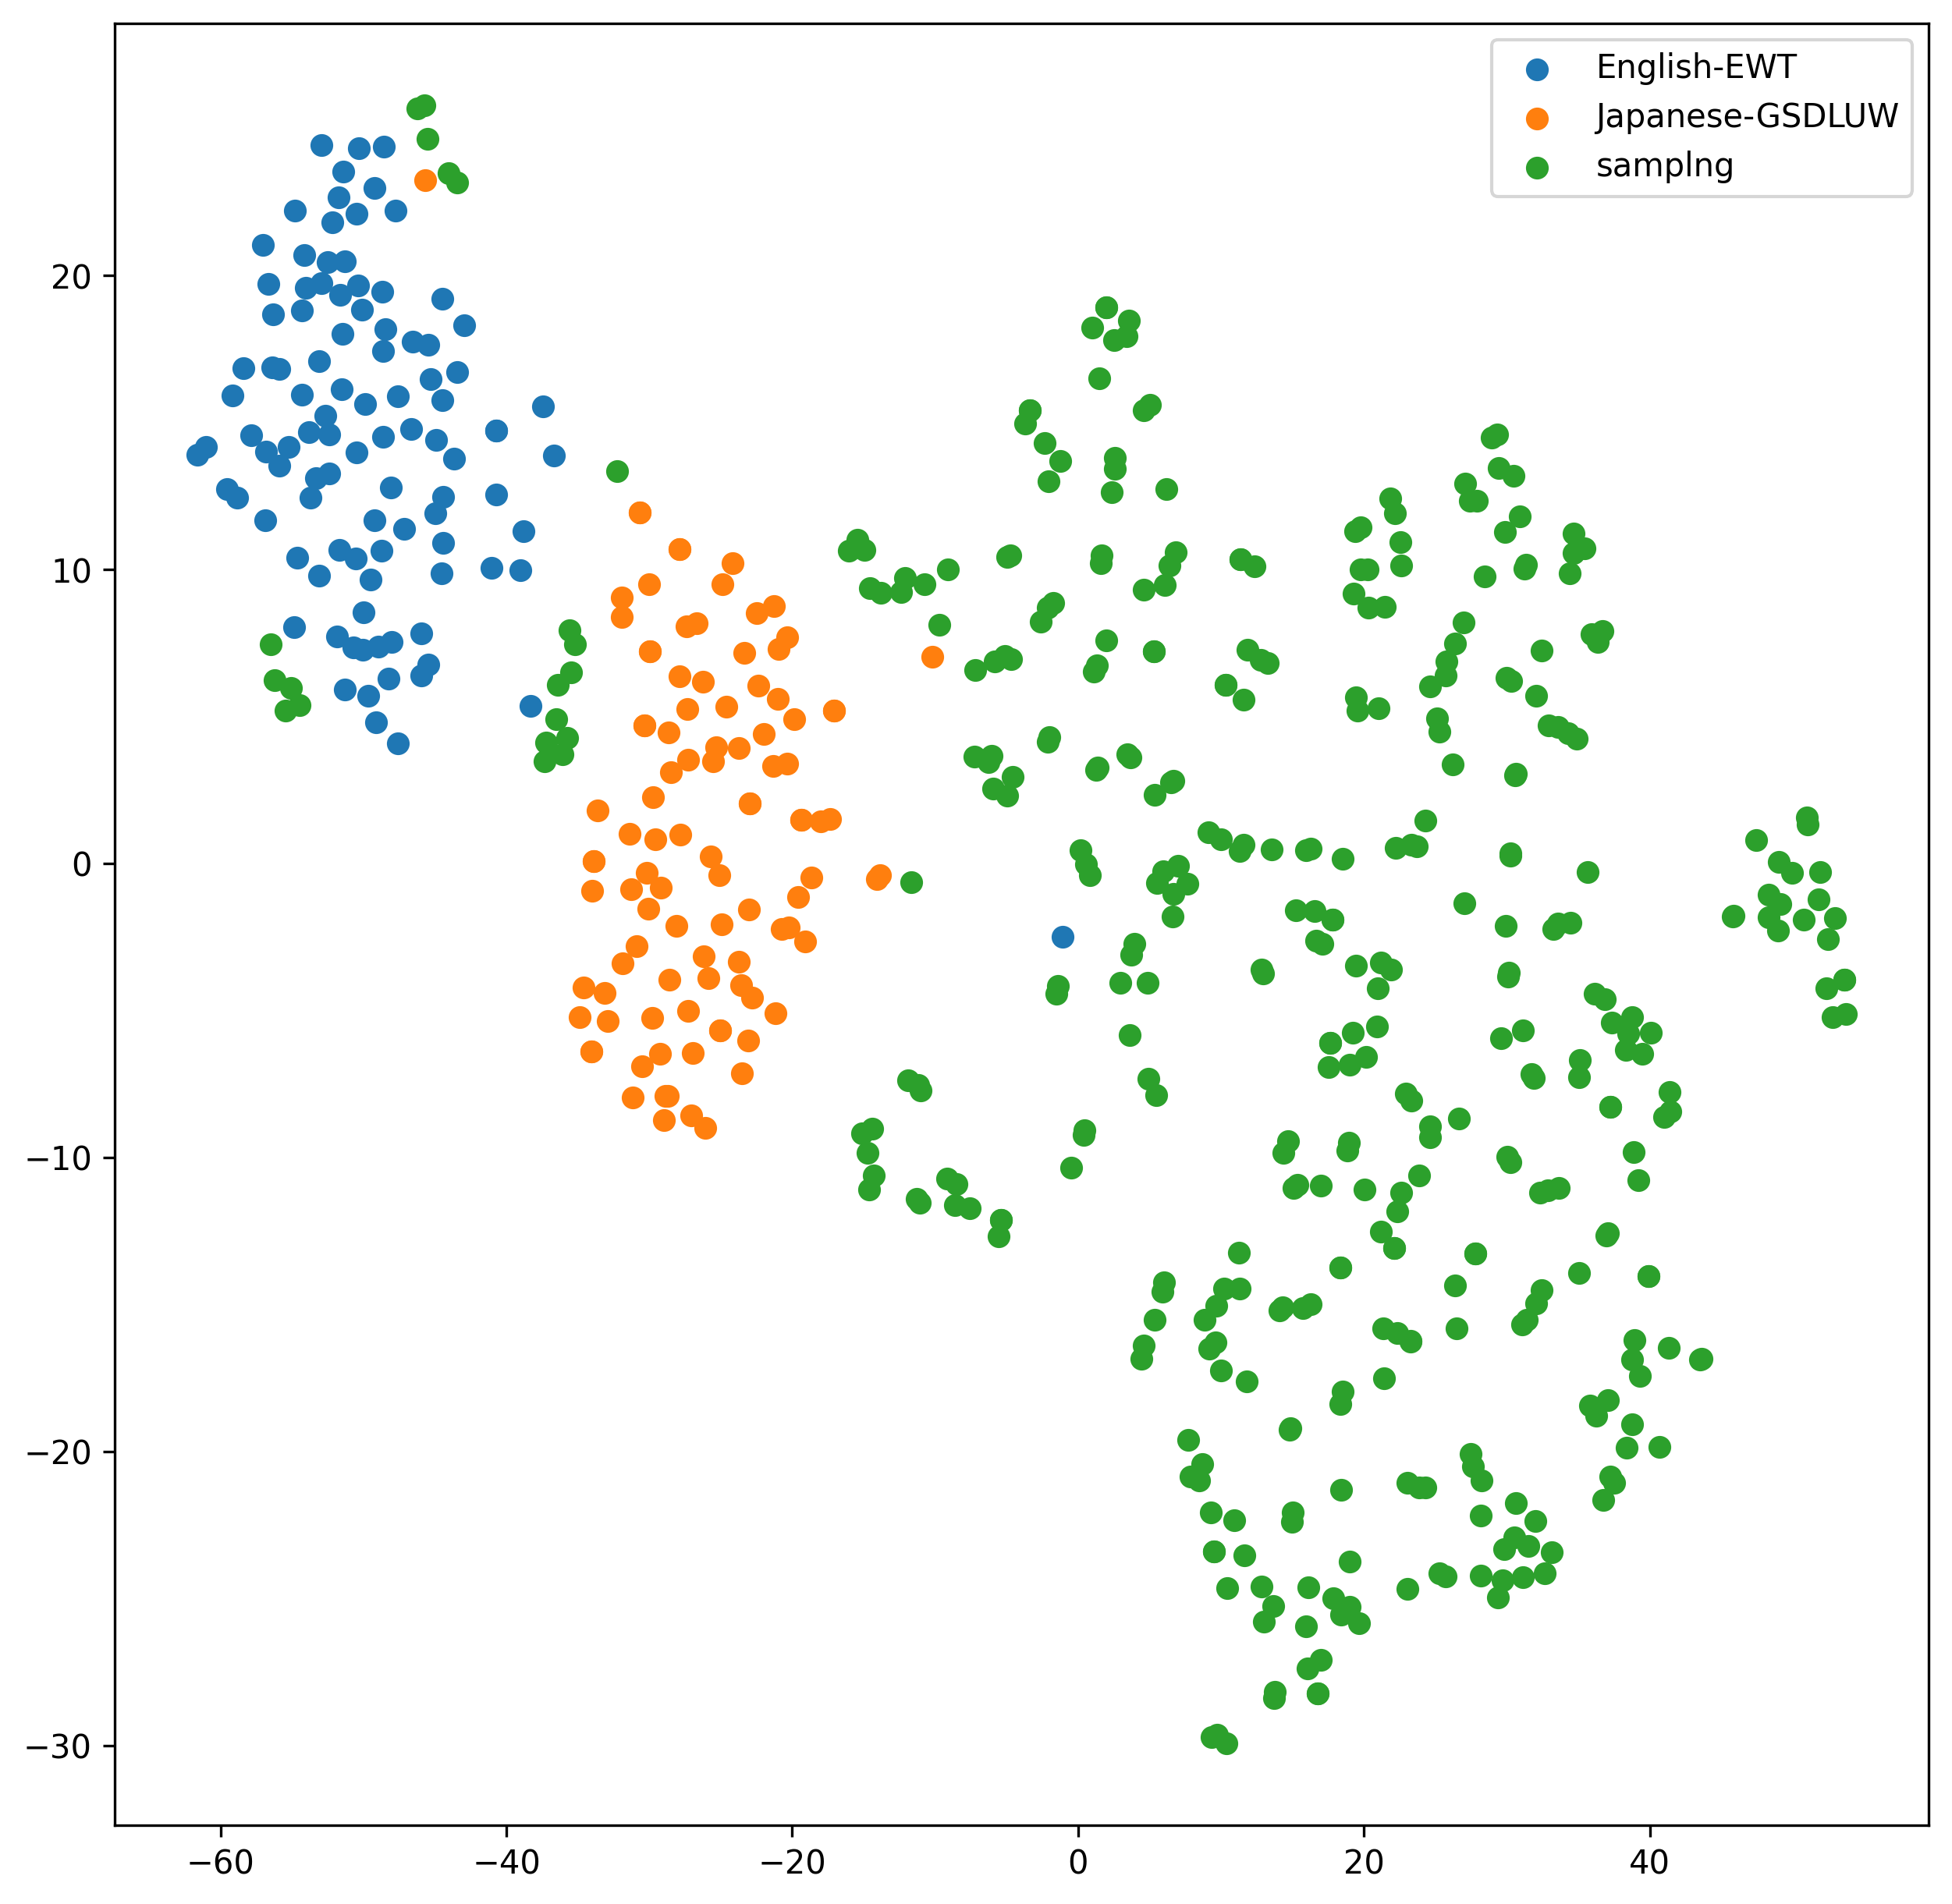

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.scatter(X_reduced_100[:100,0], X_reduced_100[:100,1], label="English-EWT")
ax.scatter(X_reduced_100[100:200,0], X_reduced_100[100:200,1], label="Japanese-GSDLUW")
ax.scatter(X_reduced_100[200:,0], X_reduced_100[200:,1], label="samplng")

ax.legend()

#plt.savefig("/home/yamazoe/zoe/figures/scatter/MCMC/mcmc_en_100.png", dpi=300, bbox_inches='tight')

## 集合の直径

In [ ]:
df = pd.DataFrame(data=np.zeros((3,4)), columns=["binary","ewt","linear","star"], index=["100","10000l","10000r"]).T

In [ ]:
df

In [ ]:
for i, init in enumerate(['binary','ewt','linear','star']):
    for j, samp in enumerate(['100','10000l','10000r']):
        A = globals()[f"tree_{init}_{samp}_zss"]  
        df[samp, init] = calc_diameter(A)

In [ ]:
df.to_csv("/home/yamazoe/zoe/data/csv/diameter_mcmc.csv")

In [ ]:
l = ["English-EWT","Japanese-GSDLUW","Korean-Kaist","Chinese-GSD", "French-GSD"]
column_list = sorted(l)

In [ ]:
sorted(l)


In [ ]:
df = pd.DataFrame(data=np.zeros((2,5)), index=["treebank","diameter"]).T
df["treebank"] = column_list

In [ ]:
df

In [ ]:
LANG = sorted(["en", "ja", "ko", "ch", "fr"])
corpus_dict = {
    "en": "English-EWT",
    "ja": "Japanese-GSDLUW",
    "ko": "Korean-Kaist",
    "ch": "Chinese-GSD",
    "fr": "French-GSD"
}


In [ ]:
for i, lang in (enumerate(LANG)):
    A = globals()[f"tree_{lang}_zss"] 
    #print(lang, corpus_dict[lang])
    df.loc[i, "treebank"] = corpus_dict[lang]
    df.loc[i, "diameter"] = calc_diameter(A)

In [ ]:
df

In [ ]:
df.to_csv("/home/yamazoe/zoe/data/csv/diameter_NL.csv", index=False)

## Wasserstein距離

In [ ]:
src_tree = tree_en_zss
tar_tree = tree_ja_zss

In [ ]:
num_src = len(src_tree)
num_tar = len(tar_tree)
a = [1/num_src] * num_src
b = [1/num_tar] * num_tar

cost_matrix = np.zeros((num_src, num_tar))
for i in tqdm(range(num_src)):
    for j in range(num_tar):
        cost_matrix[i, j] = zss.simple_distance(src_tree[i], tar_tree[j])

wasserstein_distance = ot.emd2(a, b, cost_matrix, numItermax=1000000)
wasserstein_distance

In [ ]:
distance_matrix = np.zeros((5, 5))
for i, src in tqdm(enumerate(LANG[:-1])):
    for j, tar in enumerate(LANG[i:]):
        if i > j:
            continue
        A = globals()[f"tree_{src}_zss"]
        B = globals()[f"tree_{tar}_zss"]  
        distance_matrix[i, j] = calc_wasserstein_dist(A, B)
distance_matrix += distance_matrix.T - np.diag(distance_matrix.diagonal())
distance_matrix

0it [00:00, ?it/s]

KeyboardInterrupt: 

[0.5,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

## Figure 11

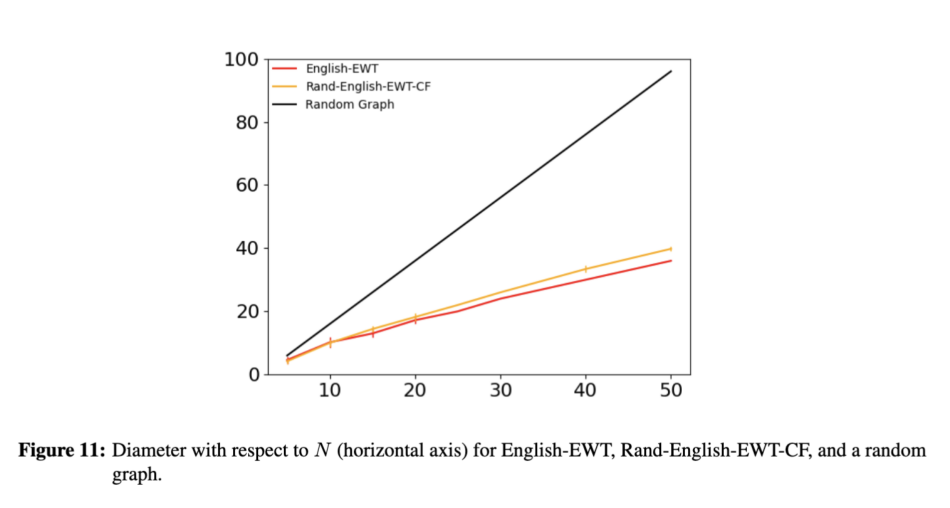

In [ ]:
img_path = "/home/yamazoe/zoe/figures/plot/Diameter_N_figure11.png"
img1 = cv2.imread(img_path)
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (12., 12.))
plt.axis('off')
plt.imshow(img2)

diameter = 2(n-1)

In [ ]:
N = 15
M = 100
J = 10
K = 10000

In [ ]:
t_init_list = [generate_random_tree(N) for step in range(M)]

In [ ]:
mcmc_list = [[] for _ in range(M)]

In [ ]:
for i in range(M):
    for step in range(K):
        t_init = t_init_list[i]
        t_init = propose_subtree_move(t_init)
        mcmc_list[i].append(t_init)

KeyboardInterrupt: 

In [ ]:
mcmc_picked = []
for mcmc_trees in mcmc_list:
    mcmc_picked += random.sample(mcmc_trees, k=10)

In [ ]:
len(mcmc_picked)

1000

In [ ]:
mcmc_trees_zss = [convert_to_zss(t) for t in mcmc_picked]
mcmc_trees_zss += tree_en_zss
tree_count = len(mcmc_trees_zss)

In [ ]:
distance_matrix = np.zeros((tree_count, tree_count))
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i, j] = zss.simple_distance(mcmc_trees_zss[i], mcmc_trees_zss[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())


  0%|          | 0/1100 [00:00<?, ?it/s]

In [ ]:
np.save(DIST_MX_DIR + "rand_1000.npy", distance_matrix)

In [ ]:
reduced = tsne_distmx(DIST_MX_DIR + "rand_1000.npy")

In [ ]:
distance_matrix.max()

18.0

In [ ]:
N=10

Text(0.5, 1.0, '$N=20$')

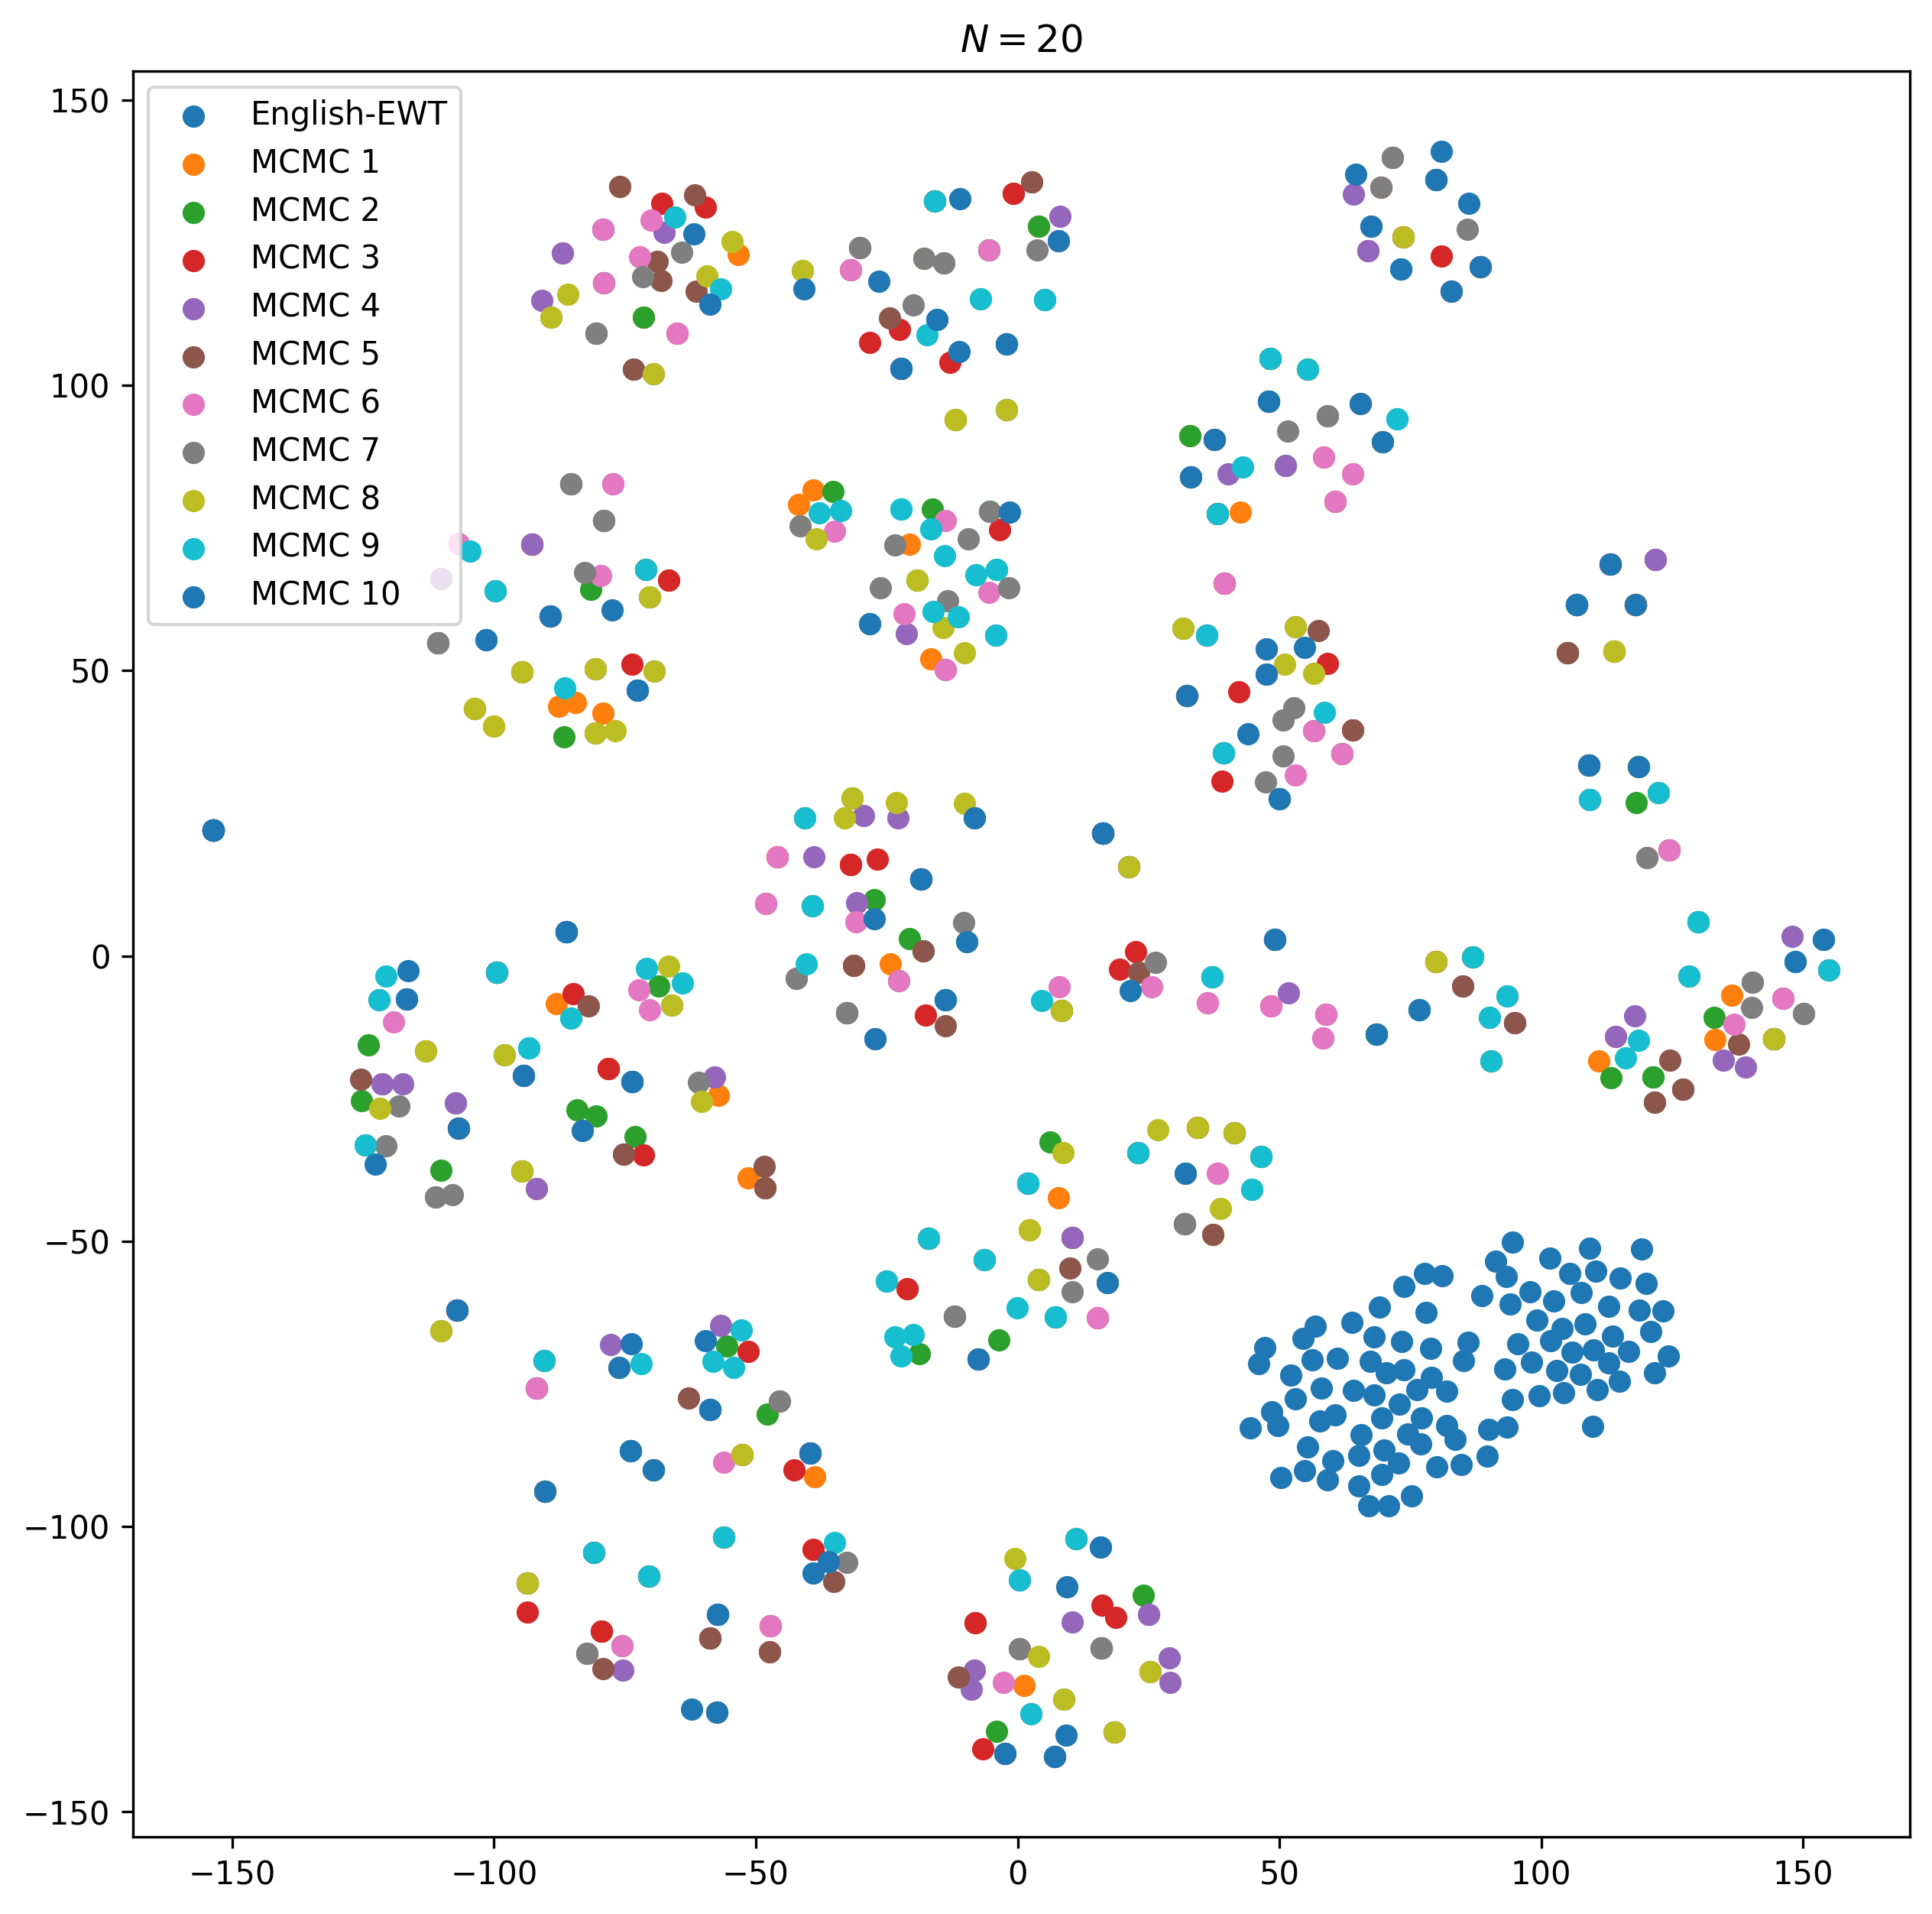

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.scatter(reduced[-100:,0], reduced[-100:,1], label="English-EWT")
for i in range(10):
    ax.scatter(reduced[i*100:(i+1)*100,0], reduced[i*100:(i+1)*100,1], label=f"MCMC {i+1}")


ax.legend()
ax.set_title(r"$N=20$")

Text(0.5, 1.0, '$N=20$')

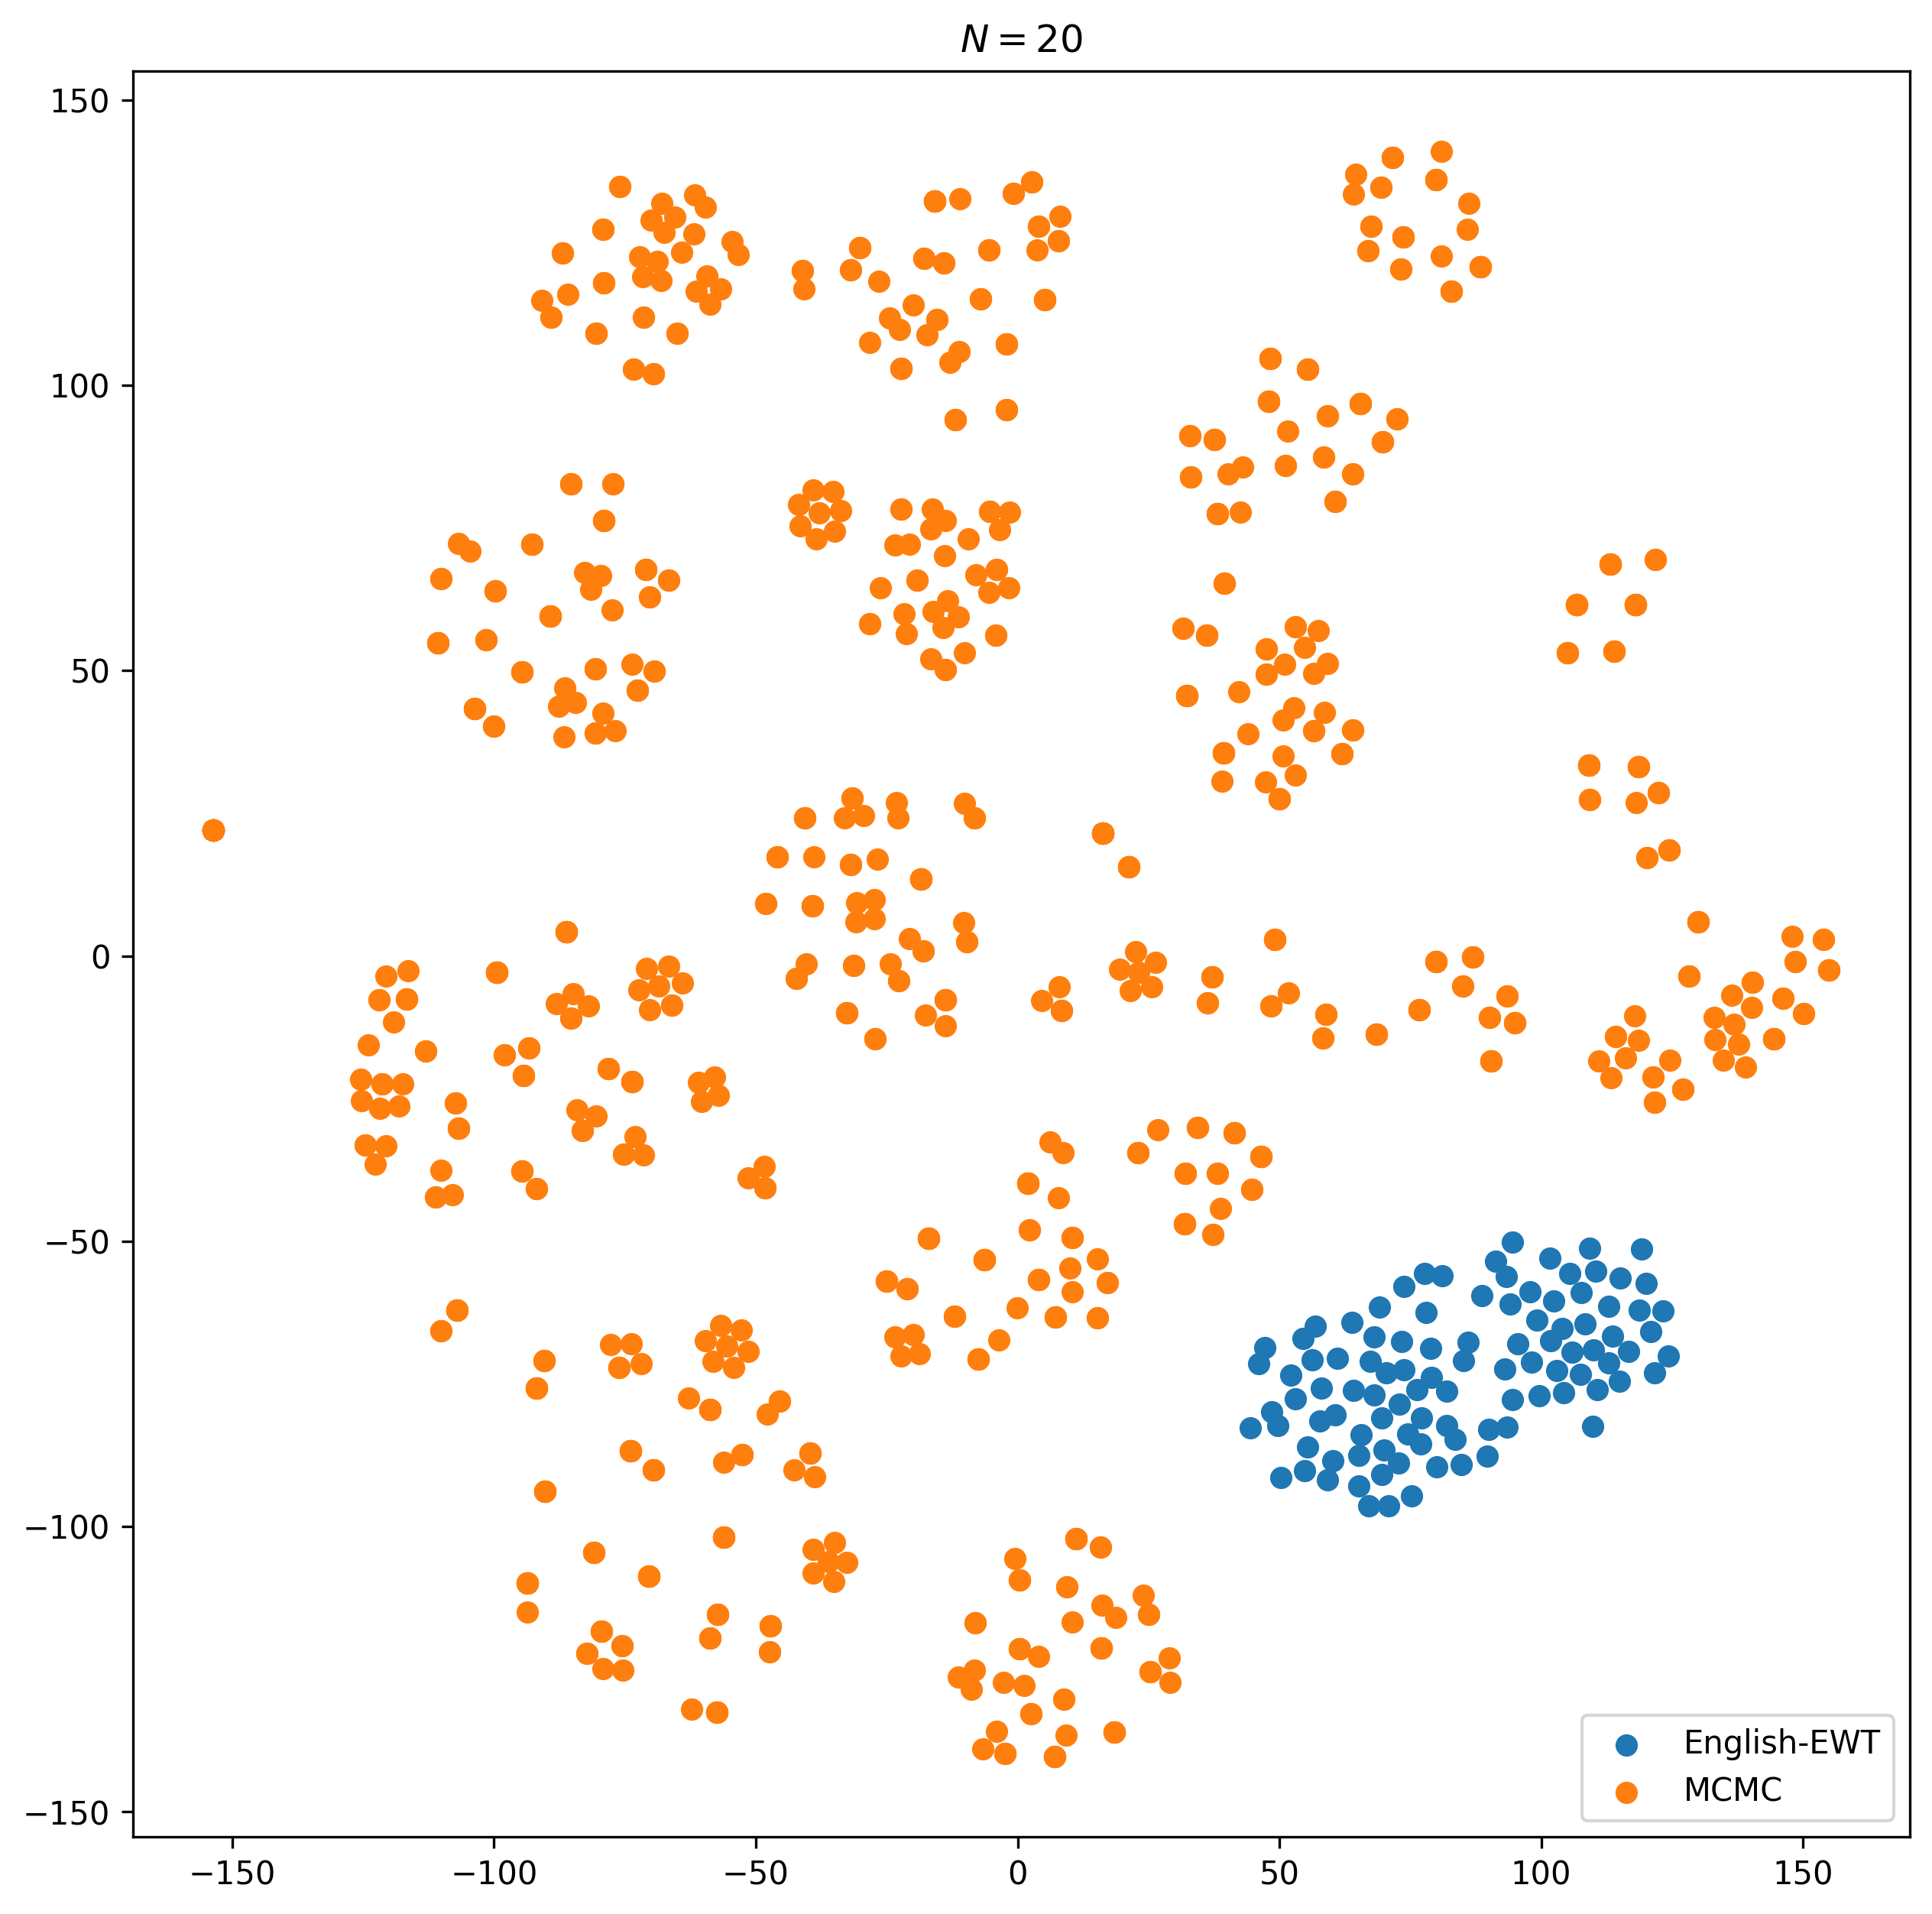

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.scatter(reduced[-100:,0], reduced[-100:,1], label="English-EWT")
ax.scatter(reduced[:-100,0], reduced[:-100,1], label="MCMC")


ax.legend(loc='lower right')
ax.set_title(r"$N=20$")

In [ ]:
N = 20
M = 100
J = 10
K = 10000

In [ ]:
t_init_list = [generate_random_tree(N) for step in range(M)]
mcmc_list = [[] for _ in range(M)]

for i in tqdm(range(M)):
    for step in range(K):
        t_init = t_init_list[i]
        t_init = propose_subtree_move(t_init)
        mcmc_list[i].append(t_init)

mcmc_picked = []
for mcmc_trees in mcmc_list:
    mcmc_picked += random.sample(mcmc_trees, k=10)

mcmc_trees_zss = [convert_to_zss(t) for t in mcmc_picked]
mcmc_trees_zss += tree_en_zss
tree_count = len(mcmc_trees_zss)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
distance_matrix = np.zeros((tree_count, tree_count))
for i in tqdm(range(tree_count)):
    for j in range(i, tree_count):
        distance_matrix[i, j] = zss.simple_distance(mcmc_trees_zss[i], mcmc_trees_zss[j])
distance_matrix = distance_matrix+distance_matrix.T-np.diag(distance_matrix.diagonal())
np.save(DIST_MX_DIR +f"rand_{N}_1000.npy", distance_matrix)

  0%|          | 0/1100 [00:00<?, ?it/s]

In [ ]:
N=5

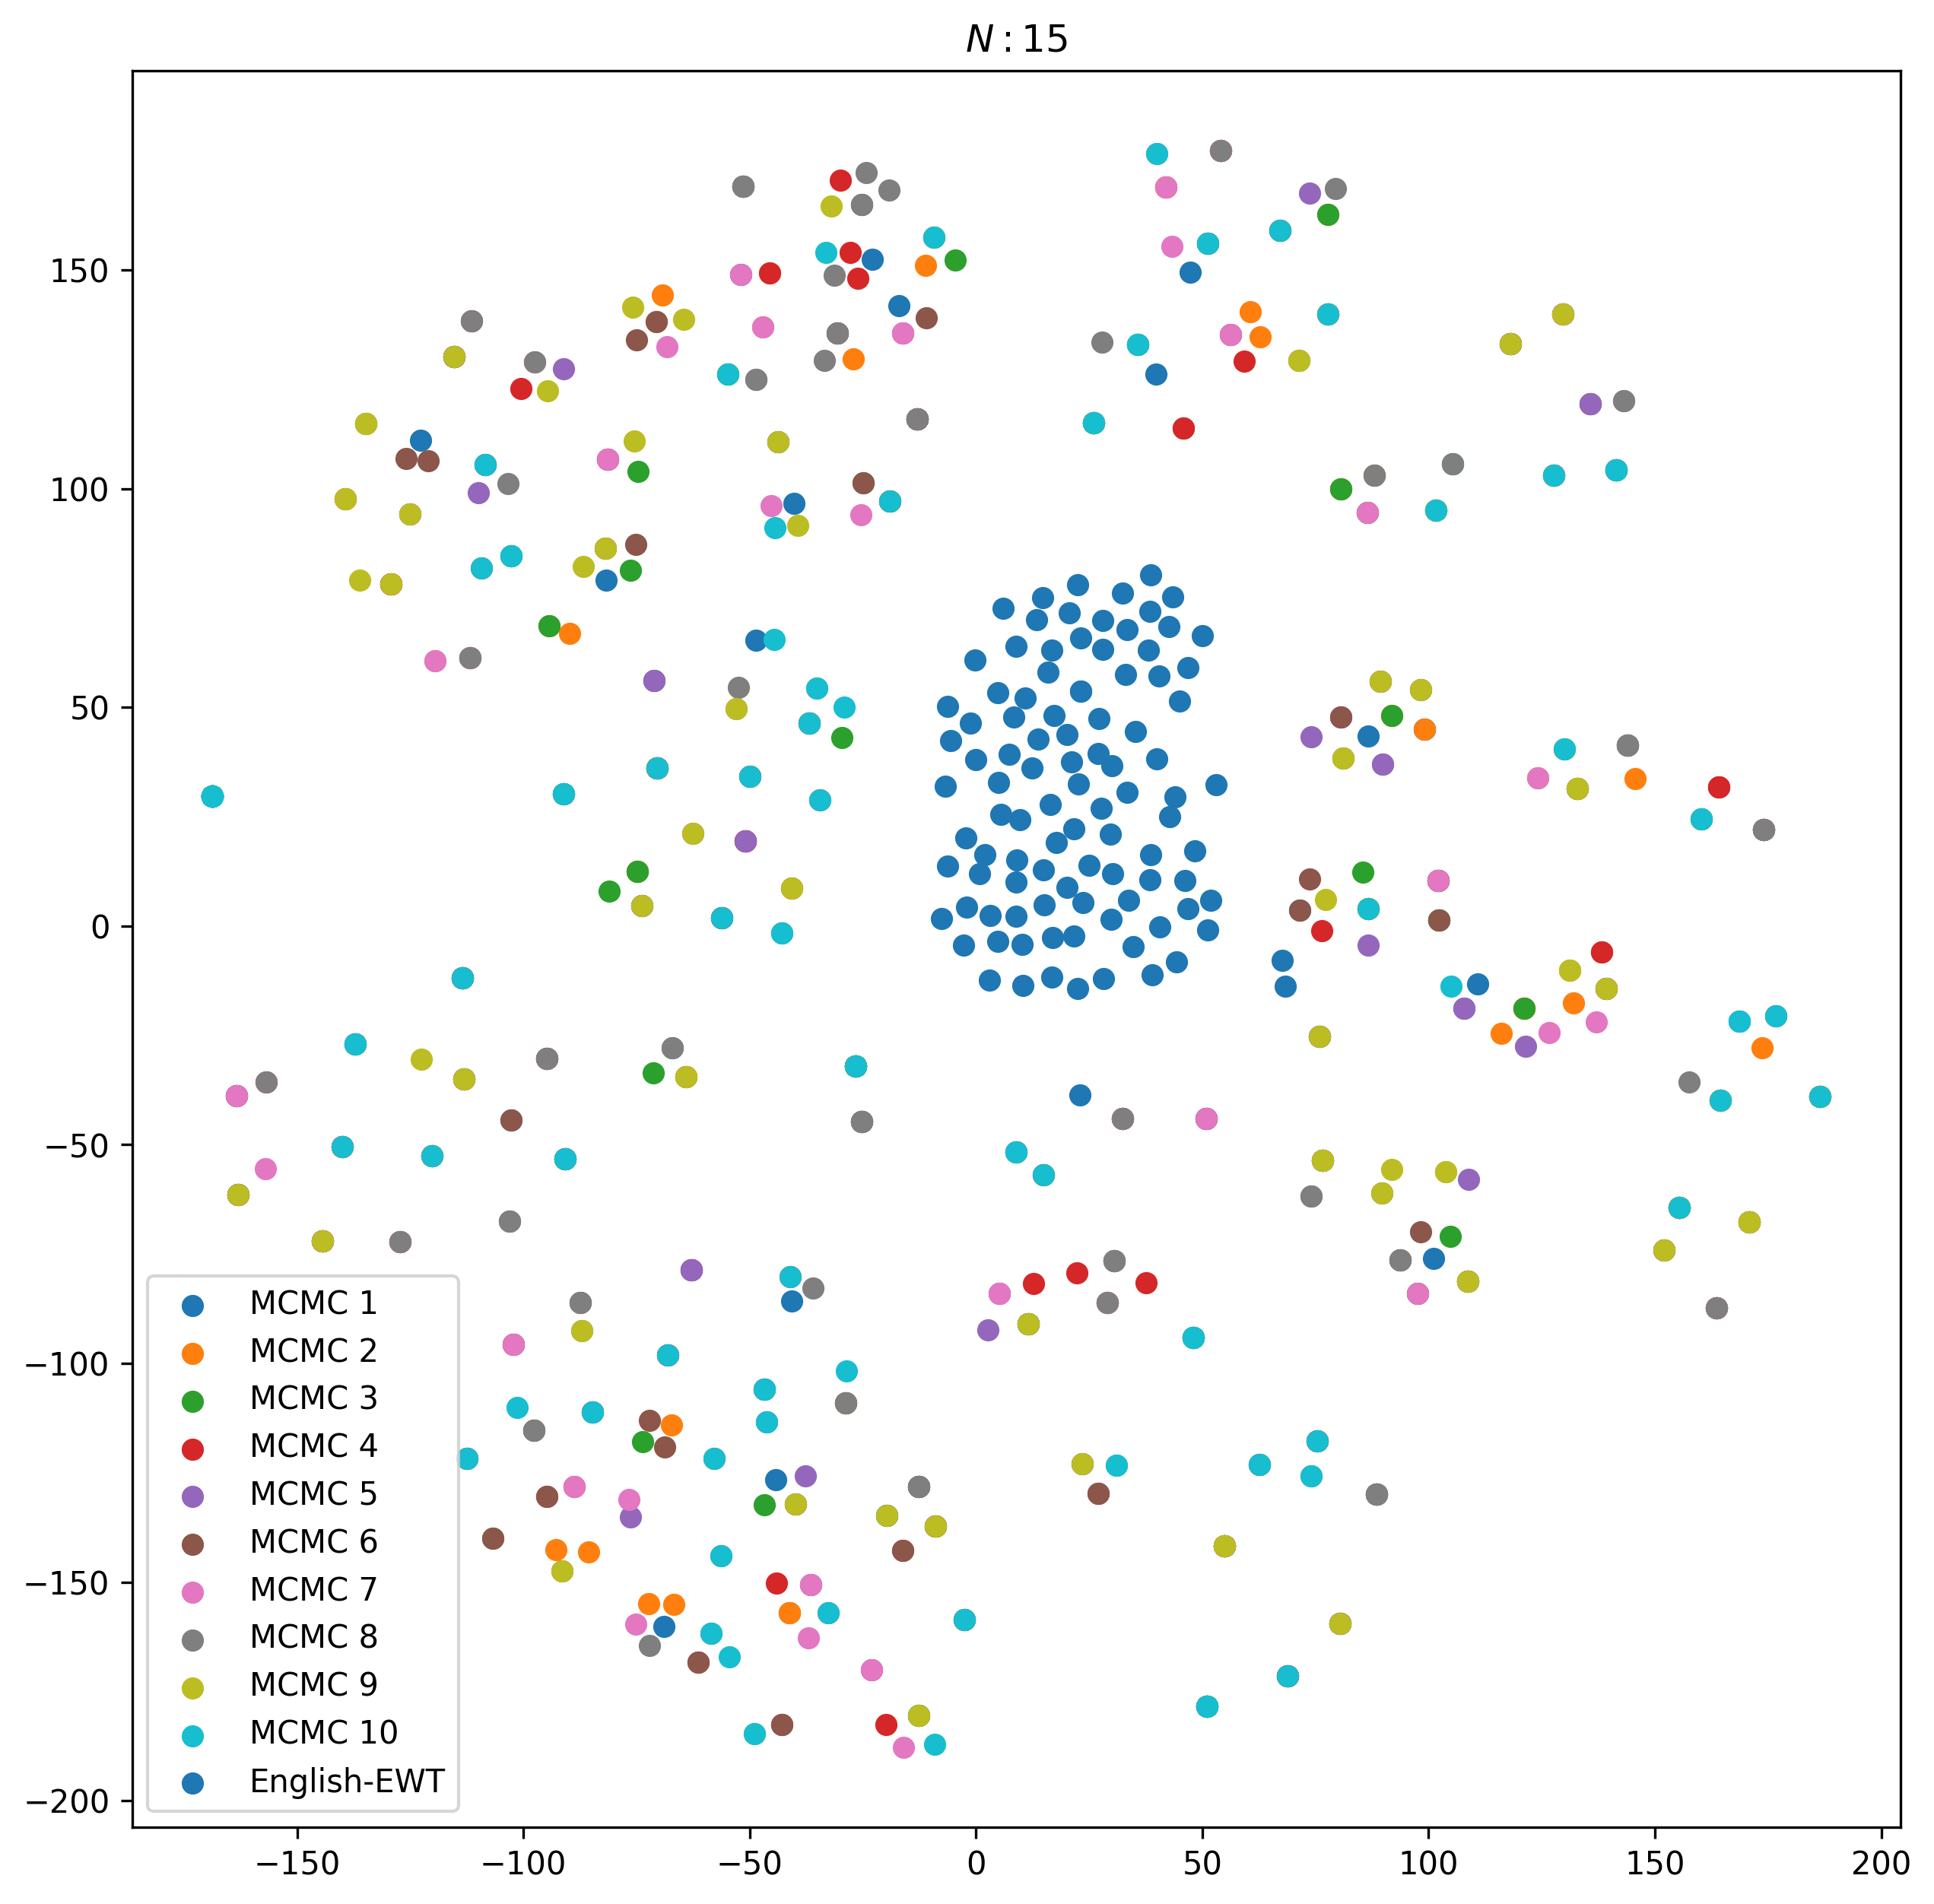

In [ ]:
reduced = tsne_distmx(DIST_MX_DIR + f"rand_{N}.npy")

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
for i in range(10):
    ax.scatter(reduced[i*100:(i+1)*100,0], reduced[i*100:(i+1)*100,1], label=f"MCMC {i+1}")
ax.scatter(reduced[-100:,0], reduced[-100:,1], label="English-EWT")

ax.legend()
ax.set_title(r"$N:$"+f"{N}")
plt.savefig(SCATTER_DIR+"rand_N/"+f"rand_{N}_colorful.png", dpi=300, bbox_inches='tight')

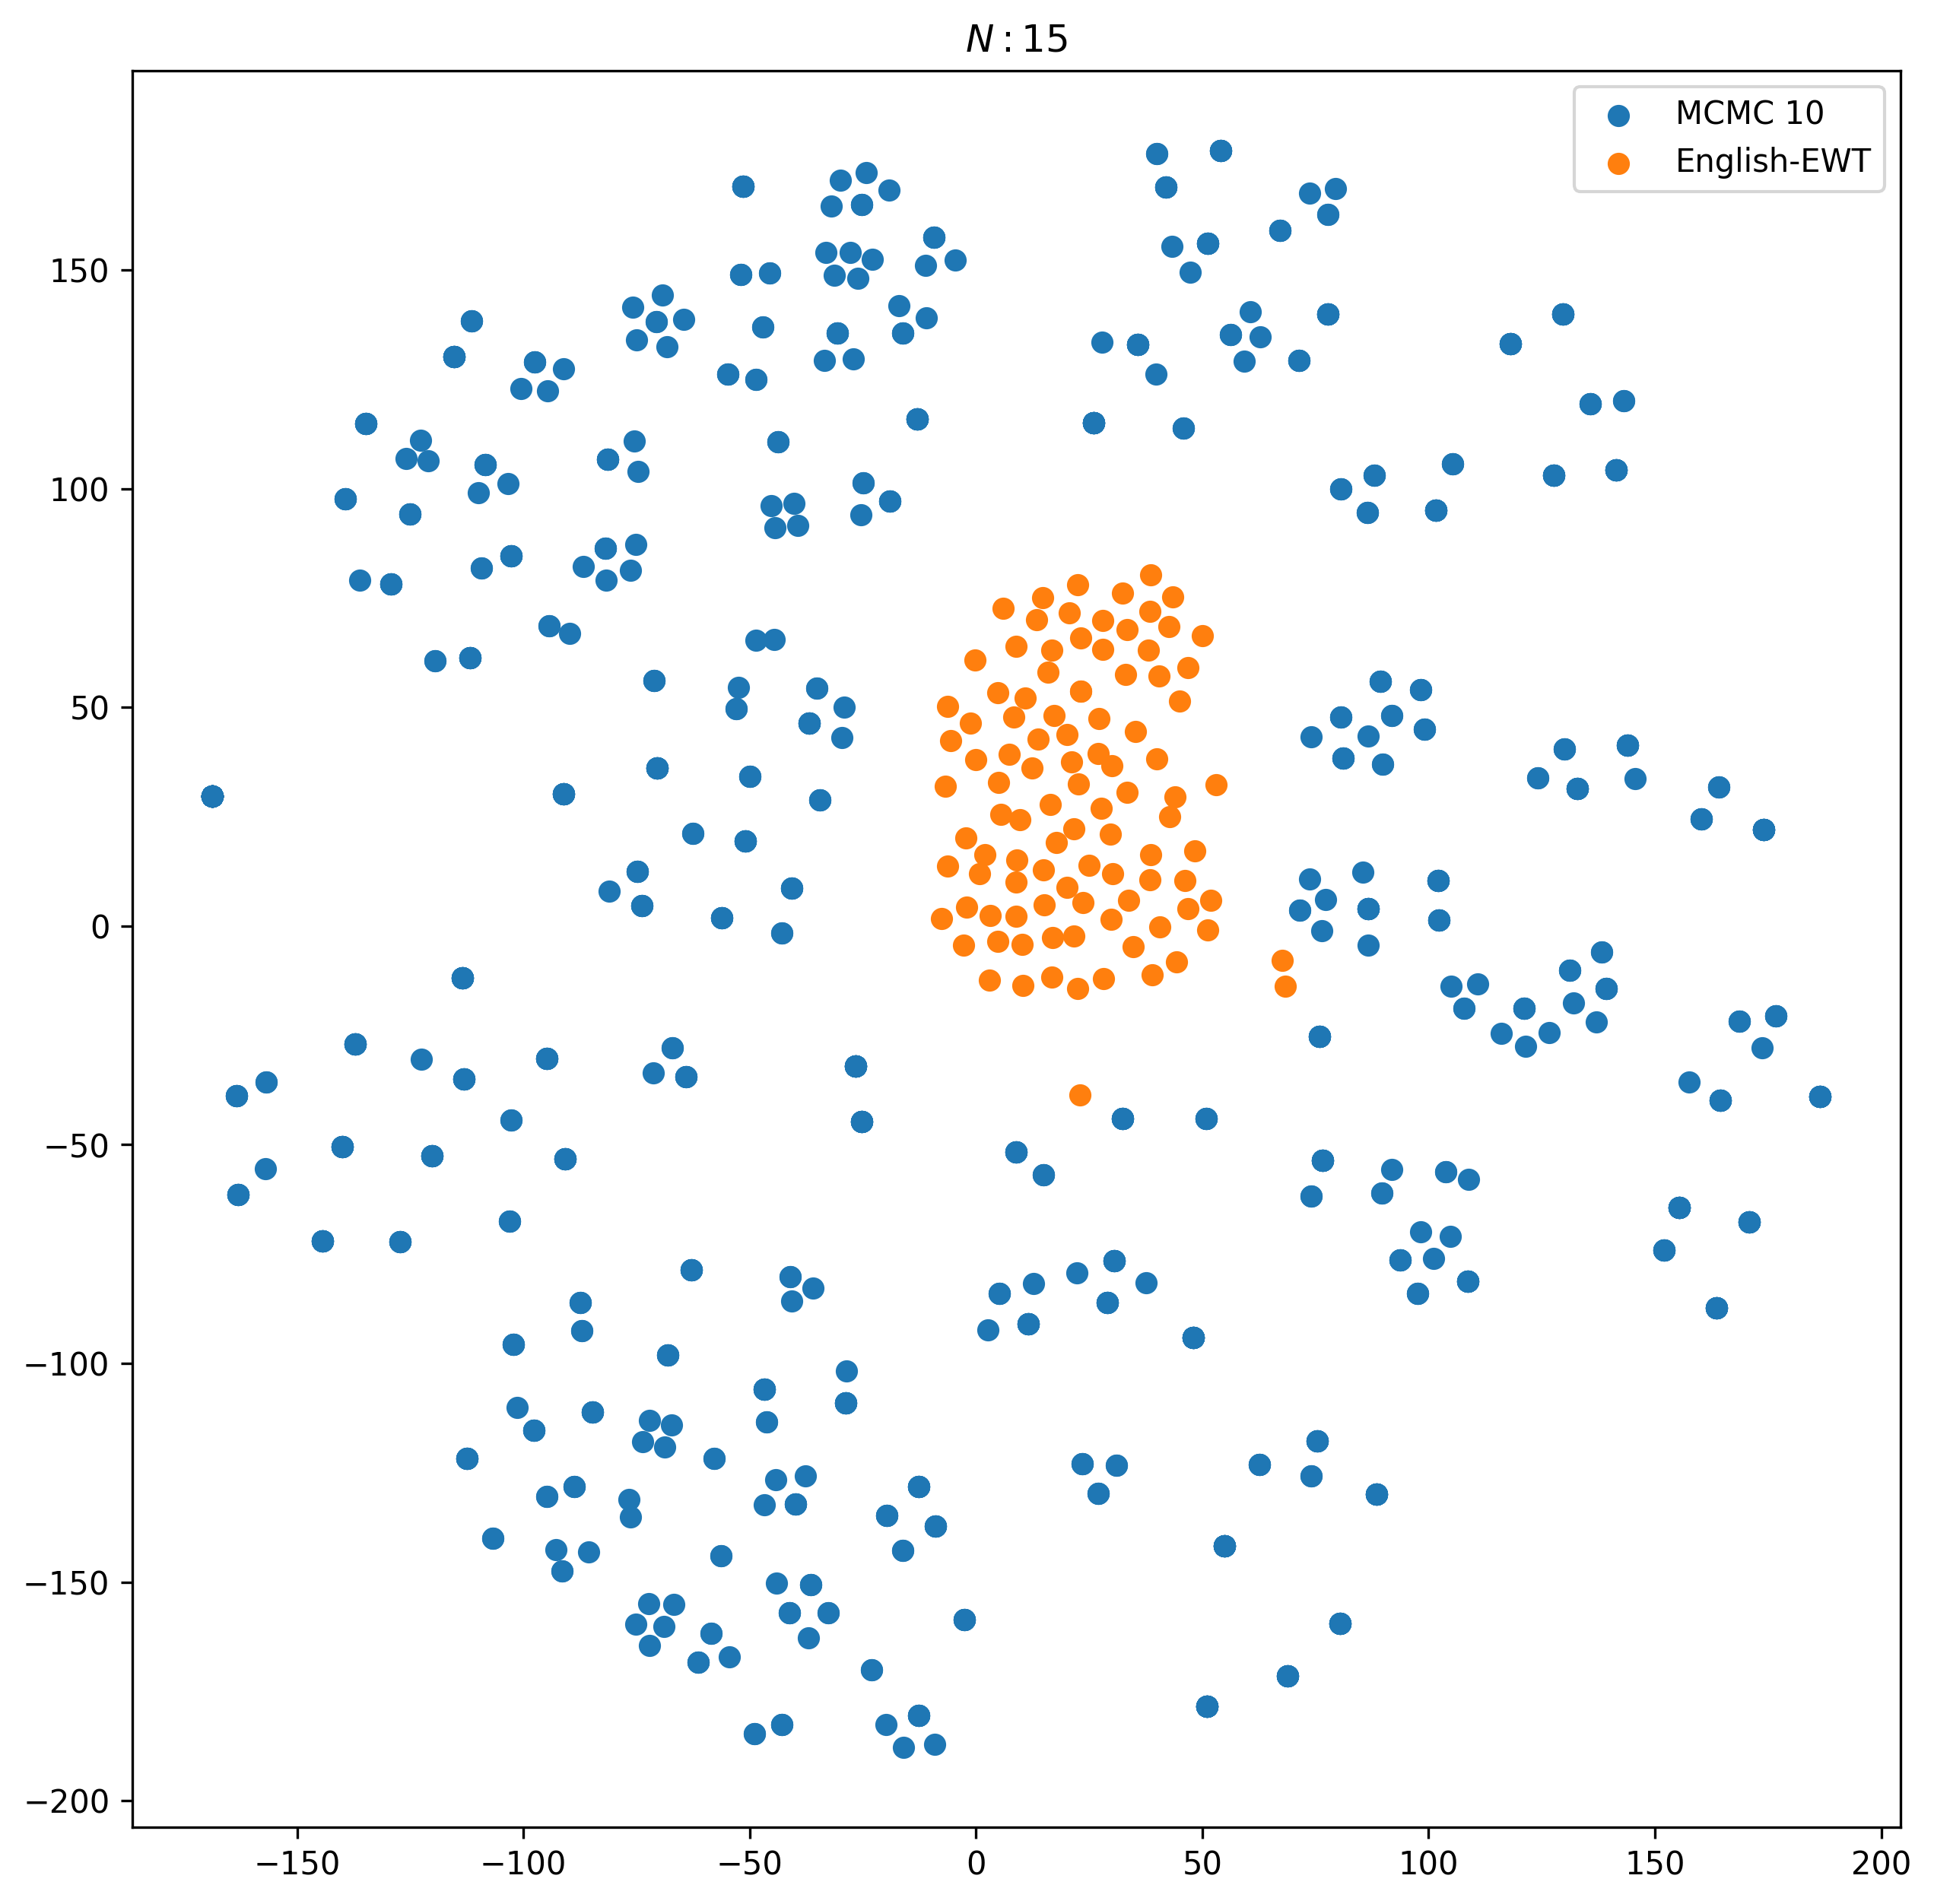

In [ ]:
reduced = tsne_distmx(DIST_MX_DIR + f"rand_{N}.npy")

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.scatter(reduced[:-100,0], reduced[:-100,1], label=f"MCMC {i+1}")
ax.scatter(reduced[-100:,0], reduced[-100:,1], label="English-EWT")

ax.legend()
ax.set_title(r"$N:$"+f"{N}")
plt.savefig(SCATTER_DIR+"rand_N/"+f"rand_{N}_twotone.png", dpi=300, bbox_inches='tight')

In [ ]:
distmx = np.load(DIST_MX_DIR + f"rand_5.npy")
distmx.max()

6.0

In [37]:
x = np.arange(5, 21)
diameter = []

In [38]:
for i in x:
    distance_matrix = np.load(DIST_MX_DIR + f"rand_{str(i)}.npy")
    print(f"rand_{i}: {distance_matrix.max()}")
    diameter.append(distance_matrix.max())

rand_5: 6.0
rand_6: 8.0
rand_7: 10.0
rand_8: 10.0
rand_9: 10.0
rand_10: 12.0
rand_11: 14.0
rand_12: 14.0
rand_13: 16.0
rand_14: 16.0
rand_15: 17.0
rand_16: 16.0
rand_17: 18.0
rand_18: 18.0
rand_19: 18.0
rand_20: 18.0


In [46]:
DIST_MX_DIR[:-9]

'/home/yamazoe/zoe/data/numpy_data/distmx/'

In [ ]:
diameter_ewt = []
for i in x[:-1]:
    distance_matrix = np.load(DIST_MX_DIR[-9] + f"ewt/rand_{str(i)}.npy")
    diameter_ewt.append(distance_matrix.max())
diameter_ewt.append(18.0)

Text(0, 0.5, 'Diameter')

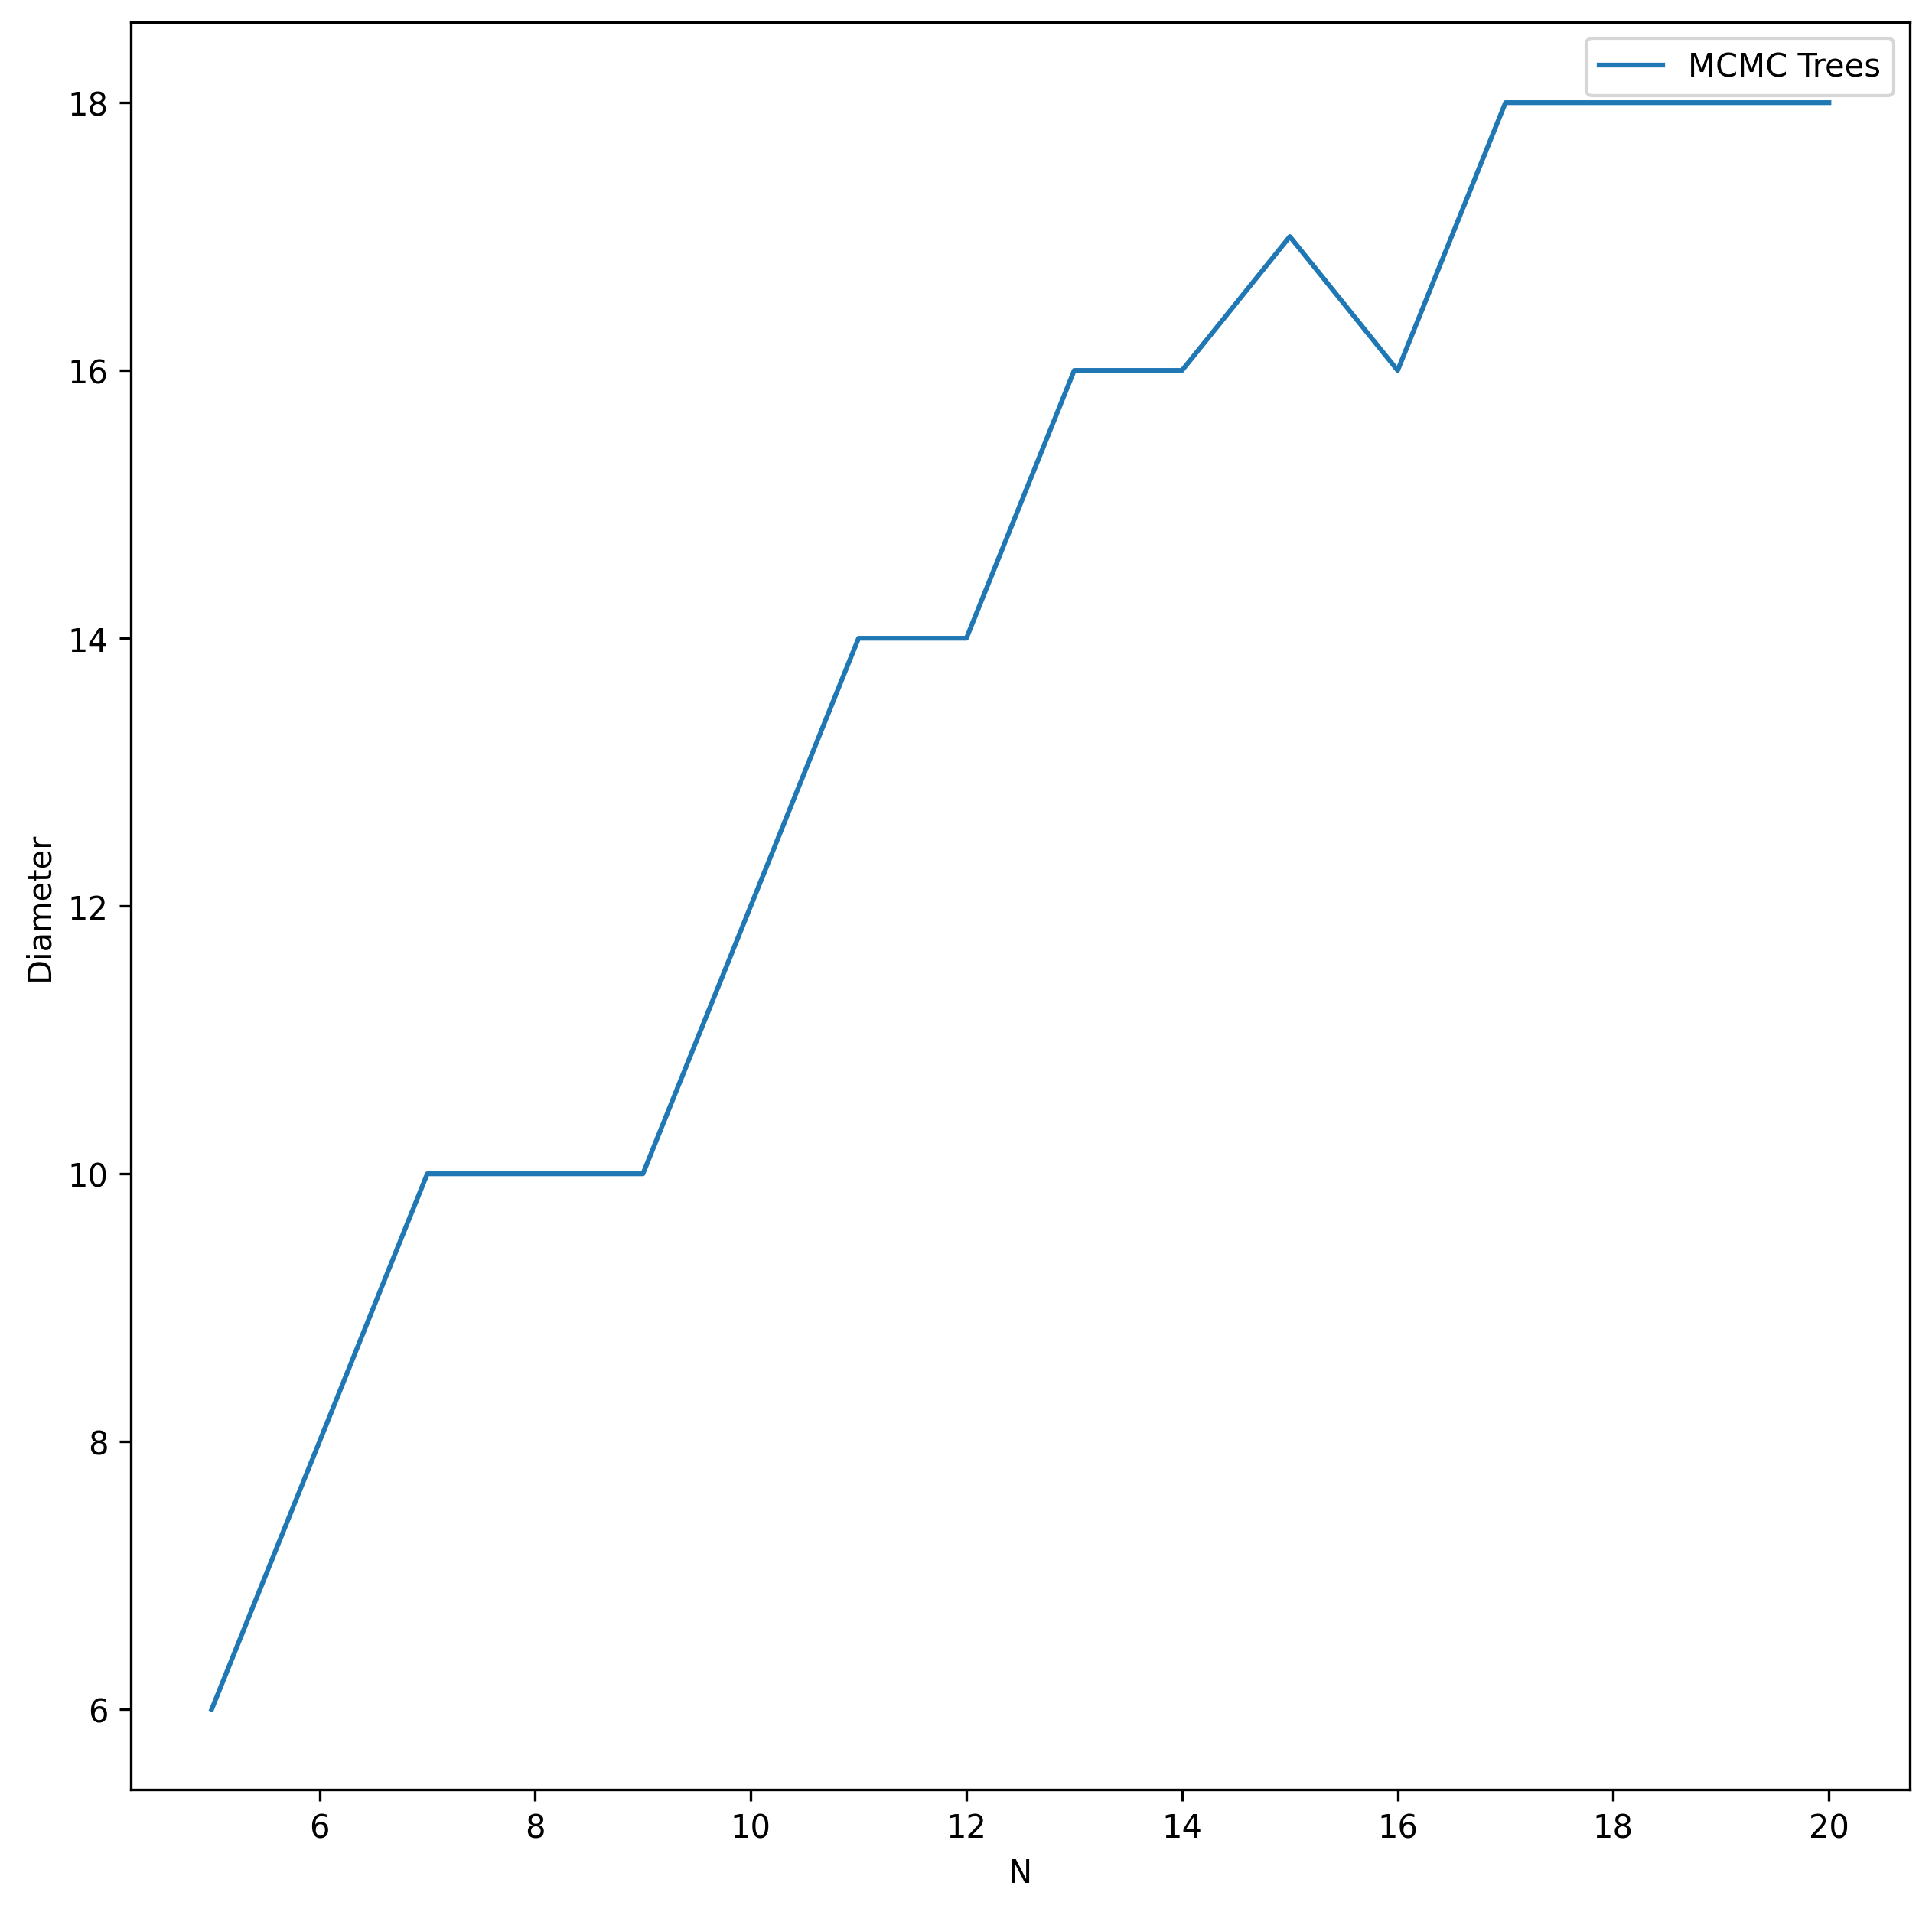

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.plot(x, diameter, marker='none', label="MCMC Trees")
ax.plot(x, diameter_ewt, marker='none', label="EWT Trees")
ax.legend()
ax.set_xlabel("N")
ax.set_ylabel("Diameter")

In [42]:
conll_en = pyconll.load_from_file(PATH_ENGLISH_EWT)
tree_en_N = []
for conll in conll_en:
    if len(conll) == N:
        tree_en_N.append(conll.to_tree())
random.seed(0)
tree_en_N = random.sample(tree_en_N, k=100)
tree_en_zss = [conll_to_zss_unlabel(tree) for tree in tree_en_N]

In [47]:
distance_matrix = np.load(DIST_MX_DIR + f"rand_{str(20)}.npy")
distance_matrix.max()

18.0